In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math

import tensorflow as tf
#tf.set_random_seed(1234)

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from sklearn.metrics import mean_squared_error

# Data preprocessing

In [ ]:
data=pd.read_csv('https://raw.githubusercontent.com/WangariKimotho/DeepL_Climate/main/Khartoum_data.csv')
data.sample(15)

LAT       LON  YEAR  MO  DY  ...  T2M_MIN    T2M  PRECTOT   QV2M   RH2M
3189  15.55131  32.53211  2018   9  25  ...    25.06  33.02     0.00  13.47  40.92
1541  15.55131  32.53211  2014   3  22  ...    16.88  26.57     0.00   2.76  12.22
2388  15.55131  32.53211  2016   7  16  ...    24.35  28.04    11.09  16.96  68.42
3901  15.55131  32.53211  2020   9   6  ...    23.93  27.97     2.47  16.53  66.74
1394  15.55131  32.53211  2013  10  26  ...    25.33  31.86     0.03   7.87  25.61
3469  15.55131  32.53211  2019   7   2  ...    28.50  34.65     0.00  12.64  35.07
3326  15.55131  32.53211  2019   2   9  ...    18.05  24.91     0.00   4.34  21.24
130   15.55131  32.53211  2010   5  11  ...    27.72  35.27     0.00   2.99   8.05
3840  15.55131  32.53211  2020   7   7  ...    27.89  32.66     0.07  13.18  40.82
1952  15.55131  32.53211  2015   5   7  ...    25.30  33.26     0.00   3.79  11.43
3500  15.55131  32.53211  2019   8   2  ...    27.20  31.43     1.06  13.99  46.58
1834  15.55131  32.53211  2015   1   9  ...     7.73  14.12     0.00   2.29  22.10
2654  15.55131  32.53211  2017   4   8  ...    23.69  31.80     0.00   4.22  13.81
1813  15.55131  32.53211  2014  12  19  ...    15.13  23.30     0.00   4.04  21.82
640   15.55131  32.53211  2011  10   3  ...    28.59  35.23     0.00   7.70  20.72

[15 rows x 13 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4138 entries, 0 to 4137
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LAT        4138 non-null   float64
 1   LON        4138 non-null   float64
 2   YEAR       4138 non-null   int64  
 3   MO         4138 non-null   int64  
 4   DY         4138 non-null   int64  
 5   T2M_RANGE  4138 non-null   float64
 6   T2MWET     4138 non-null   float64
 7   T2M_MAX    4138 non-null   float64
 8   T2M_MIN    4138 non-null   float64
 9   T2M        4138 non-null   float64
 10  PRECTOT    4138 non-null   float64
 11  QV2M       4138 non-null   float64
 12  RH2M       4138 non-null   float64
dtypes: float64(10), int64(3)
memory usage: 420.4 KB


As we can see above, we don't have a datetime type, while it is important in the rest of our work, the procedure below aims at recreating a date object from day, month, year.

In [ ]:
data['date']= data['YEAR'].map(str) +'-' + data['MO'].map(str) +'-' + data['DY'].map(str)
data.head()

LAT       LON  YEAR  MO  DY  ...    T2M  PRECTOT  QV2M   RH2M      date
0  15.55131  32.53211  2010   1   1  ...  21.80      0.0  4.92  29.11  2010-1-1
1  15.55131  32.53211  2010   1   2  ...  21.86      0.0  5.28  31.07  2010-1-2
2  15.55131  32.53211  2010   1   3  ...  22.91      0.0  4.39  24.25  2010-1-3
3  15.55131  32.53211  2010   1   4  ...  23.02      0.0  4.44  24.34  2010-1-4
4  15.55131  32.53211  2010   1   5  ...  22.27      0.0  4.16  23.89  2010-1-5

[5 rows x 14 columns]

In [ ]:
data['dater'] = pd.to_datetime(data['date'], dayfirst=True)
data.head()

LAT       LON  YEAR  MO  DY  ...  PRECTOT  QV2M   RH2M      date      dater
0  15.55131  32.53211  2010   1   1  ...      0.0  4.92  29.11  2010-1-1 2010-01-01
1  15.55131  32.53211  2010   1   2  ...      0.0  5.28  31.07  2010-1-2 2010-01-02
2  15.55131  32.53211  2010   1   3  ...      0.0  4.39  24.25  2010-1-3 2010-01-03
3  15.55131  32.53211  2010   1   4  ...      0.0  4.44  24.34  2010-1-4 2010-01-04
4  15.55131  32.53211  2010   1   5  ...      0.0  4.16  23.89  2010-1-5 2010-01-05

[5 rows x 15 columns]

In [ ]:
data=data.drop('date',axis=1)
data.head()

LAT       LON  YEAR  MO  DY  ...    T2M  PRECTOT  QV2M   RH2M      dater
0  15.55131  32.53211  2010   1   1  ...  21.80      0.0  4.92  29.11 2010-01-01
1  15.55131  32.53211  2010   1   2  ...  21.86      0.0  5.28  31.07 2010-01-02
2  15.55131  32.53211  2010   1   3  ...  22.91      0.0  4.39  24.25 2010-01-03
3  15.55131  32.53211  2010   1   4  ...  23.02      0.0  4.44  24.34 2010-01-04
4  15.55131  32.53211  2010   1   5  ...  22.27      0.0  4.16  23.89 2010-01-05

[5 rows x 14 columns]

Then we continue by deleting the missing values.

In [ ]:
df = data[data['T2M'] >0]
df.shape

(4136, 14)

# Temperature Forecasting

We are interested first of all in the temperature, so we group together the two columns that interest us, the temperature and the date.

In [ ]:
df1=df[['dater','T2M']]
df1.head()

dater    T2M
0 2010-01-01  21.80
1 2010-01-02  21.86
2 2010-01-03  22.91
3 2010-01-04  23.02
4 2010-01-05  22.27

In [ ]:
df2 = df1.set_index('dater')
df2

T2M
dater            
2010-01-01  21.80
2010-01-02  21.86
2010-01-03  22.91
2010-01-04  23.02
2010-01-05  22.27
...           ...
2021-04-24  34.70
2021-04-25  35.12
2021-04-26  33.65
2021-04-27  33.40
2021-04-28  33.43

[4136 rows x 1 columns]

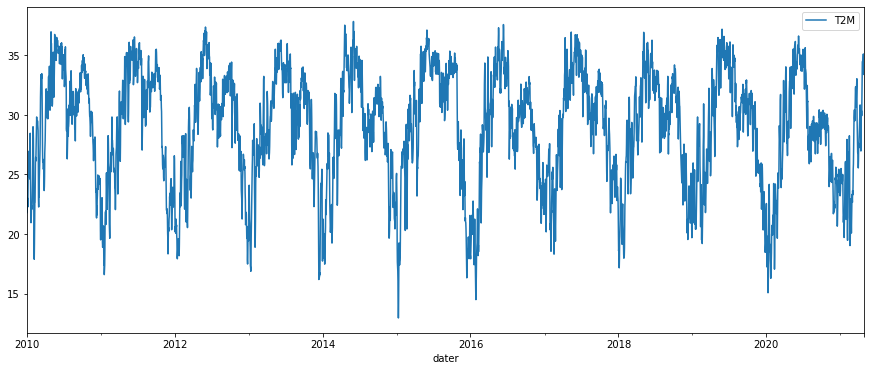

In [ ]:
fig,ax = plt.subplots(figsize=(15,6))
df2.plot(kind='line',ax=ax)
plt.show()

Above we have the temperature variation curve of the last 10 years in Karthoum, from a global view there is not a drastic variation, the temperature is relatively stable. However, the years 2015 and 2019 attract our attention, so we will investigate to understand this difference in trend compared to the other years.

In [ ]:
df1['year'] = df1['dater'].dt.year
df1['quarter'] = df1['dater'].dt.quarter

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df1.head()

dater    T2M  year  quarter
0 2010-01-01  21.80  2010        1
1 2010-01-02  21.86  2010        1
2 2010-01-03  22.91  2010        1
3 2010-01-04  23.02  2010        1
4 2010-01-05  22.27  2010        1

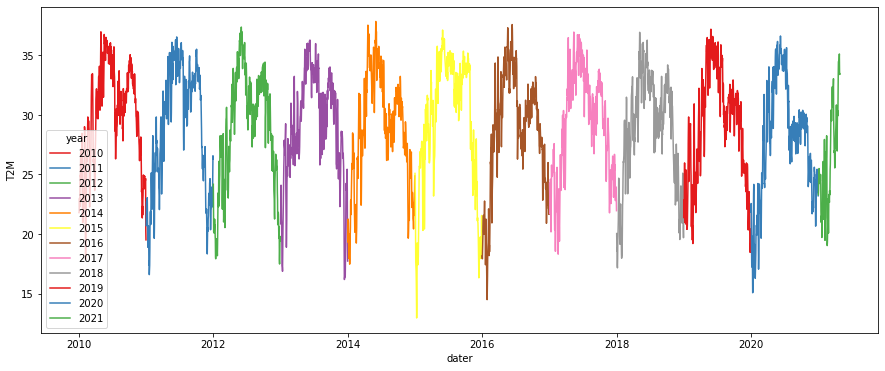

In [ ]:
plt.figure(figsize=(15,6))
sns.lineplot(x='dater',y='T2M',data=df1,hue='year',palette='Set1')
plt.show()

In [ ]:
df2 = df[['T2M','YEAR']].groupby(by='YEAR').mean().reset_index()
df2.head()

YEAR        T2M
0  2010  29.985205
1  2011  29.012986
2  2012  28.873661
3  2013  29.140767
4  2014  28.884493

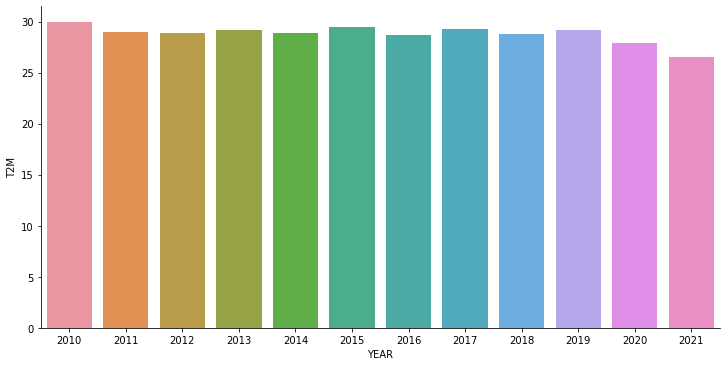

In [ ]:
sns.catplot(x='YEAR',y='T2M',data=df2,kind='bar',aspect=2)

In [ ]:
df.head(2)

LAT       LON  YEAR  MO  DY  ...    T2M  PRECTOT  QV2M   RH2M      dater
0  15.55131  32.53211  2010   1   1  ...  21.80      0.0  4.92  29.11 2010-01-01
1  15.55131  32.53211  2010   1   2  ...  21.86      0.0  5.28  31.07 2010-01-02

[2 rows x 14 columns]

In [ ]:
def YearPlotsKDEHist(year):
    plt.figure(figsize=(14, 10))
    plt.title('Monthly Temperature ')
    labels = ['Jan' , 'Feb' , 'Mar' , 'Apr' , 'May' , 
          'Jun' , 'Jul' , 'Aug' , 'Sept' , 'Oct' , 'Nov' , 'Dec']
    df_year = df[ df['YEAR'] == year ]
    for month in range(1, 13):
    
        plt.subplot(3, 4, month)
        sns.kdeplot(df_year[df_year['MO'] == month]['T2M'] , color=colors1[month-1])
        plt.xlabel(labels[month-1])

In [ ]:
colors1 =['b', 'g', 'r', 'c', 'm', 'y' ,  
          'aqua' , 'antiquewhite' , 'cornflowerblue'  , 
          'forestgreen'  , 'mediumslateblue'   ,'tan']
len(colors1)

12

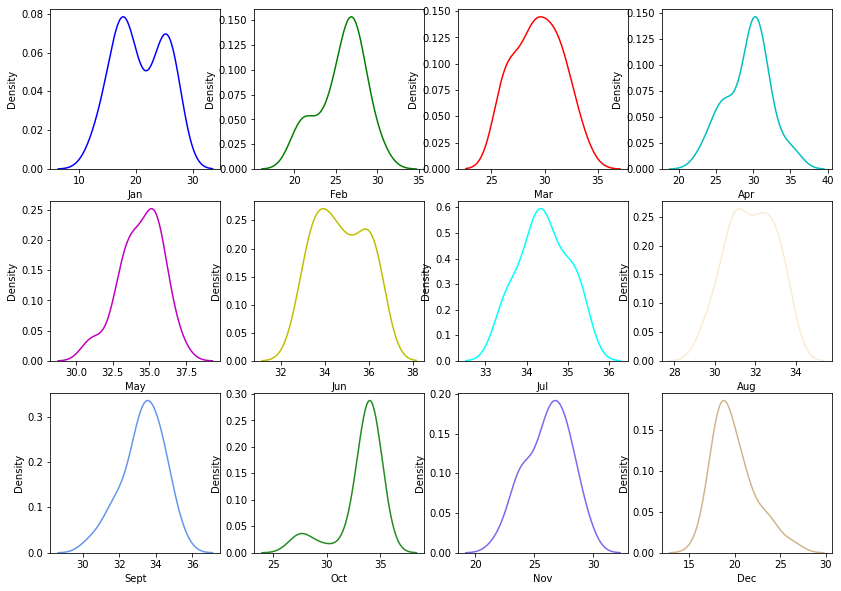

In [ ]:
YearPlotsKDEHist(2015)

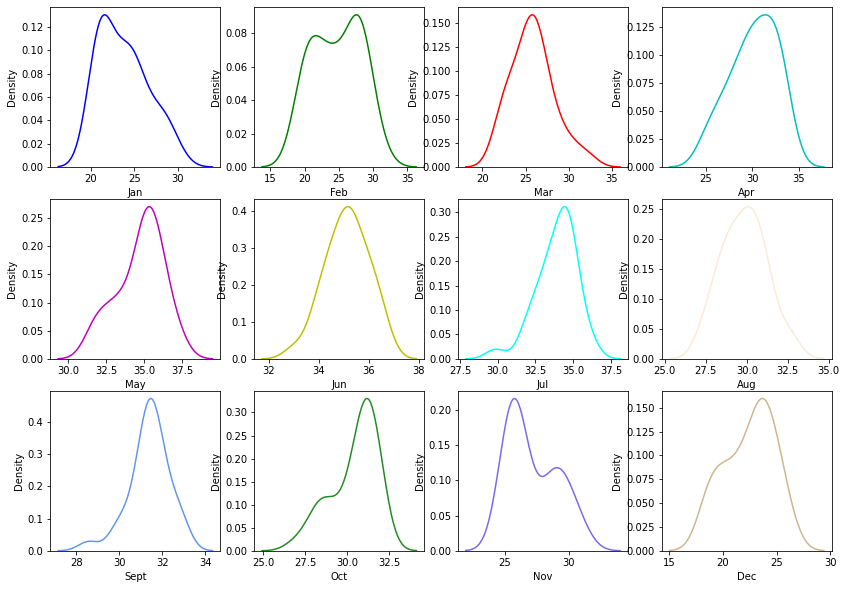

In [ ]:
YearPlotsKDEHist(2019)

## Splitting and training the model

In [ ]:
temp=df['T2M']
temp

0       21.80
1       21.86
2       22.91
3       23.02
4       22.27
        ...  
4131    34.70
4132    35.12
4133    33.65
4134    33.40
4135    33.43
Name: T2M, Length: 4136, dtype: float64

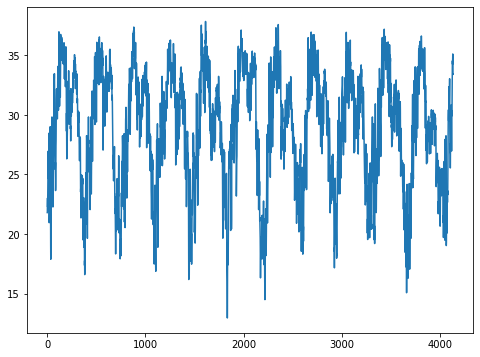

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(temp)

In [ ]:
def ReScaleAroundZero(data, a):
    data_avg = data.mean()
    scaled_data = a*(data - data_avg)
    return scaled_data

In [ ]:
MaxTemp_Rescaled  = ReScaleAroundZero(temp , 0.1)

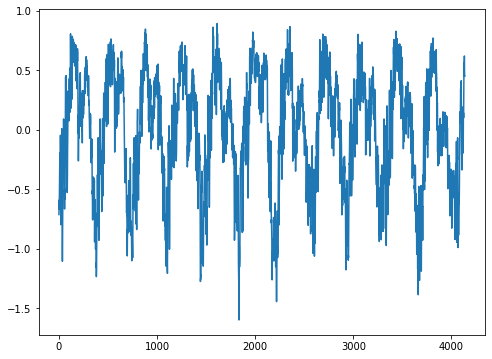

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(MaxTemp_Rescaled)

In [ ]:
MaxTempScaledValues = pd.DataFrame(MaxTemp_Rescaled)

df_new = pd.concat([MaxTempScaledValues.shift(6),MaxTempScaledValues.shift(5),MaxTempScaledValues.shift(4),MaxTempScaledValues.shift(3),MaxTempScaledValues.shift(2),MaxTempScaledValues.shift(1), MaxTempScaledValues], axis=1)
df_new.columns = ['t-5','t-4','t-3','t-2','t-1' ,'t','t+1']
df_new = df_new.dropna(how= 'any')
df_new.head(5)

t-5       t-4       t-3       t-2       t-1         t       t+1
6  -0.713341 -0.707341 -0.602341 -0.591341 -0.666341 -0.570341 -0.400341
7  -0.707341 -0.602341 -0.591341 -0.666341 -0.570341 -0.400341 -0.411341
8  -0.602341 -0.591341 -0.666341 -0.570341 -0.400341 -0.411341 -0.339341
9  -0.591341 -0.666341 -0.570341 -0.400341 -0.411341 -0.339341 -0.213341
10 -0.666341 -0.570341 -0.400341 -0.411341 -0.339341 -0.213341 -0.197341

In [ ]:
df_new.iloc[:,:]

t-5       t-4       t-3       t-2       t-1         t       t+1
6    -0.713341 -0.707341 -0.602341 -0.591341 -0.666341 -0.570341 -0.400341
7    -0.707341 -0.602341 -0.591341 -0.666341 -0.570341 -0.400341 -0.411341
8    -0.602341 -0.591341 -0.666341 -0.570341 -0.400341 -0.411341 -0.339341
9    -0.591341 -0.666341 -0.570341 -0.400341 -0.411341 -0.339341 -0.213341
10   -0.666341 -0.570341 -0.400341 -0.411341 -0.339341 -0.213341 -0.197341
...        ...       ...       ...       ...       ...       ...       ...
4131  0.253659  0.451659  0.552659  0.557659  0.561659  0.532659  0.576659
4132  0.451659  0.552659  0.557659  0.561659  0.532659  0.576659  0.618659
4133  0.552659  0.557659  0.561659  0.532659  0.576659  0.618659  0.471659
4134  0.557659  0.561659  0.532659  0.576659  0.618659  0.471659  0.446659
4135  0.561659  0.532659  0.576659  0.618659  0.471659  0.446659  0.449659

[4130 rows x 7 columns]

In [ ]:
n_points = len(df_new)
train_points = int(9/10*n_points)
X_train, X_test =df_new.iloc[:train_points , [0 , 1 , 2, 3, 4]], df_new.iloc[train_points :, [0 , 1 , 2, 3, 4]]
y_train, y_test =df_new.iloc[:train_points: , [5, 6]],  df_new.iloc[train_points: , [5, 6]]
print("We have", len(X_train), "training points and", X_test.shape[0], "testing points")

We have 3717 training points and 413 testing points


In [ ]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
keras.backend.clear_session()

X_train1 = np.array(X_train).reshape(X_train.shape[0],X_train.shape[1], 1)
X_test1 = np.array(X_test).reshape(X_test.shape[0],X_test.shape[1], 1)
print(X_train1.shape)
print(X_test1.shape)

(3717, 5, 1)
(413, 5, 1)


In [ ]:
X_train.head()

t-5       t-4       t-3       t-2       t-1
6  -0.713341 -0.707341 -0.602341 -0.591341 -0.666341
7  -0.707341 -0.602341 -0.591341 -0.666341 -0.570341
8  -0.602341 -0.591341 -0.666341 -0.570341 -0.400341
9  -0.591341 -0.666341 -0.570341 -0.400341 -0.411341
10 -0.666341 -0.570341 -0.400341 -0.411341 -0.339341

In [ ]:
y_test.head()

t       t+1
3723  0.234659  0.278659
3724  0.278659 -0.471341
3725 -0.471341 -0.467341
3726 -0.467341 -0.503341
3727 -0.503341 -0.428341

## LSTM

### Architecture of LSTM

![LSTM](https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/The_LSTM_Cell.svg/300px-The_LSTM_Cell.svg.png)

### BUILDING MODEL

In [ ]:
model1 = Sequential()
model1.add(LSTM(21,return_sequences=True,activation="relu",input_shape = (X_train1.shape[1],X_train1.shape[2])))
model1.add(LSTM(21,activation="relu"))
model1.add(Dense(1))
model1.compile(loss="mean_squared_error",optimizer = "adam")

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 21)             1932      
_________________________________________________________________
lstm_1 (LSTM)                (None, 21)                3612      
_________________________________________________________________
dense (Dense)                (None, 1)                 22        
Total params: 5,566
Trainable params: 5,566
Non-trainable params: 0
_________________________________________________________________


### TRAINING THE MODEL

In [ ]:
nb_epoch = 150

model1.fit(X_train1, y_train, epochs=nb_epoch)

Epoch 1/150
117/117 [==============================] - 6s 15ms/step - loss: 0.1905
Epoch 2/150
117/117 [==============================] - 2s 16ms/step - loss: 0.0438
Epoch 3/150
117/117 [==============================] - 2s 15ms/step - loss: 0.0373
Epoch 4/150
117/117 [==============================] - 2s 15ms/step - loss: 0.0279
Epoch 5/150
117/117 [==============================] - 2s 16ms/step - loss: 0.0241
Epoch 6/150
117/117 [==============================] - 2s 16ms/step - loss: 0.0230
Epoch 7/150
117/117 [==============================] - 2s 15ms/step - loss: 0.0217
Epoch 8/150
117/117 [==============================] - 2s 16ms/step - loss: 0.0243
Epoch 9/150
117/117 [==============================] - 2s 15ms/step - loss: 0.0225
Epoch 10/150
117/117 [==============================] - 2s 16ms/step - loss: 0.0225
Epoch 11/150
117/117 [==============================] - 2s 15ms/step - loss: 0.0233
Epoch 12/150
117/117 [==============================] - 2s 15ms/step - loss: 0.0225
E

### PREDICTING

In [ ]:
y_train_pred_LSTM = model1.predict(X_train1)
y_test_pred_LSTM = model1.predict(X_test1)

In [ ]:
mean_squared_error(y_train_pred_LSTM , y_train.iloc[:,-1])

0.029977838051536747

### TRAINING ACCURACY

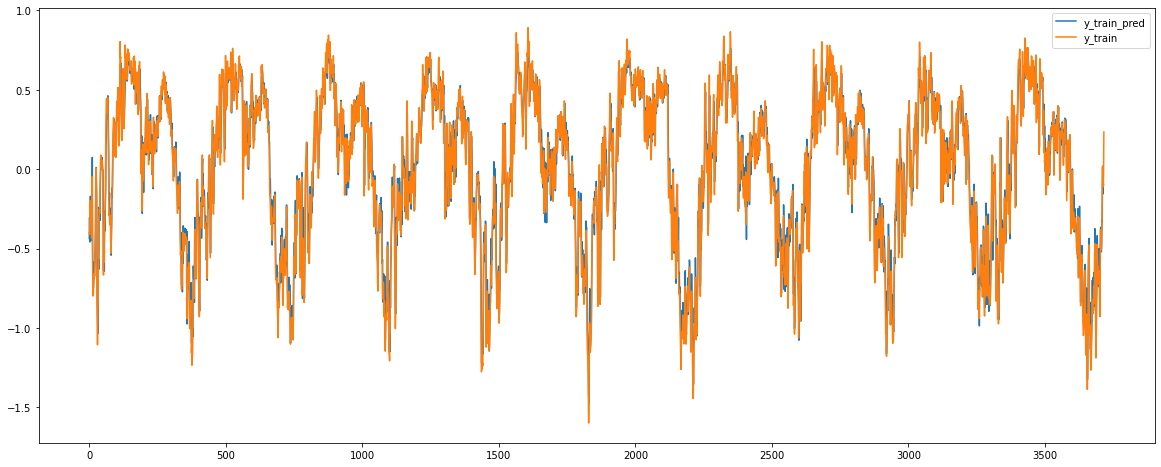

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y_train_pred_LSTM[1:])),y_train_pred_LSTM[1:],label ='y_train_pred' )
plt.plot(np.arange(len(y_train.iloc[:,-1])), y_train.iloc[:,-1], label ='y_train')
plt.legend(loc='upper right')

In [ ]:
mean_squared_error(y_test_pred_LSTM , y_test.iloc[:,-1])

0.02955510240768605

### TESTING ACCURACY

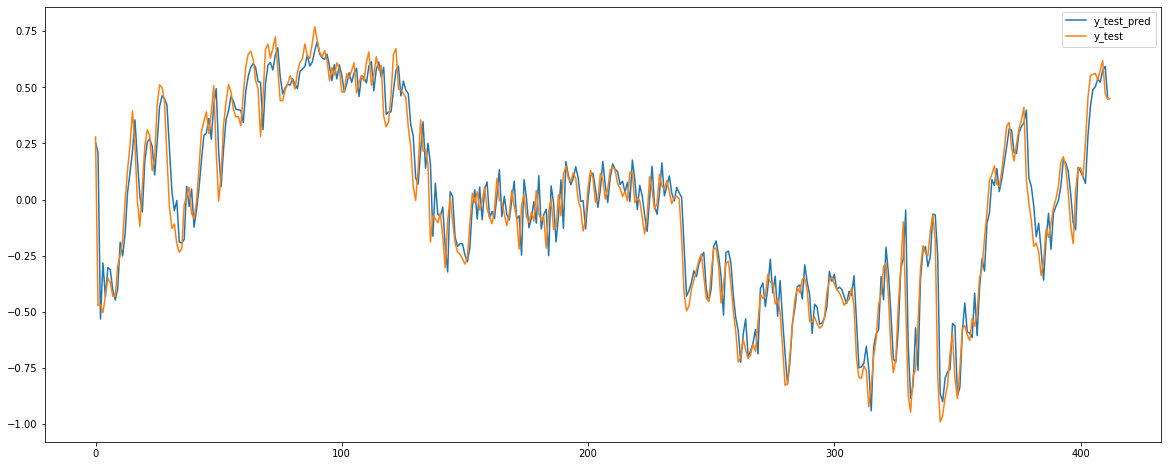

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y_test_pred_LSTM[1:])),y_test_pred_LSTM[1:],label ='y_test_pred' )
plt.plot(np.arange(len(y_test.iloc[:,-1])), y_test.iloc[:,-1], label ='y_test')
plt.legend(loc='best')

##Short term prediction from long-term history data

In [ ]:
df_new2 = pd.concat([MaxTempScaledValues.shift(15),MaxTempScaledValues.shift(14),MaxTempScaledValues.shift(13),MaxTempScaledValues.shift(12),MaxTempScaledValues.shift(11),MaxTempScaledValues.shift(10),MaxTempScaledValues.shift(9),MaxTempScaledValues.shift(8),MaxTempScaledValues.shift(7),MaxTempScaledValues.shift(6),MaxTempScaledValues.shift(5),MaxTempScaledValues.shift(4),MaxTempScaledValues.shift(3),MaxTempScaledValues.shift(2),MaxTempScaledValues.shift(1),MaxTempScaledValues], axis=1)
df_new2.columns = ['t-14','t-13','t-12','t-11','t-10','t-9','t-8','t-7','t-6','t-5','t-4','t-3','t-2','t-1','t','t+1']
df_new2 = df_new2.dropna(how= 'any')
df_new2.head(5)

t-14      t-13      t-12  ...       t-1         t       t+1
15 -0.713341 -0.707341 -0.602341  ... -0.349341 -0.431341 -0.418341
16 -0.707341 -0.602341 -0.591341  ... -0.431341 -0.418341 -0.047341
17 -0.602341 -0.591341 -0.666341  ... -0.418341 -0.047341 -0.290341
18 -0.591341 -0.666341 -0.570341  ... -0.047341 -0.290341 -0.647341
19 -0.666341 -0.570341 -0.400341  ... -0.290341 -0.647341 -0.730341

[5 rows x 16 columns]

In [ ]:
df_new2 = df_new2.iloc[-200:,:]
df_new2.shape

(200, 16)

In [ ]:
df_new2

t-14      t-13      t-12  ...       t-1         t       t+1
3936 -0.140341 -0.085341  0.052659  ...  0.131659  0.070659  0.050659
3937 -0.085341  0.052659  0.130659  ...  0.070659  0.050659  0.013659
3938  0.052659  0.130659  0.094659  ...  0.050659  0.013659  0.036659
3939  0.130659  0.094659 -0.011341  ...  0.013659  0.036659 -0.006341
3940  0.094659 -0.011341 -0.004341  ...  0.036659 -0.006341  0.122659
...        ...       ...       ...  ...       ...       ...       ...
4131  0.190659  0.145659  0.030659  ...  0.561659  0.532659  0.576659
4132  0.145659  0.030659 -0.117341  ...  0.532659  0.576659  0.618659
4133  0.030659 -0.117341 -0.196341  ...  0.576659  0.618659  0.471659
4134 -0.117341 -0.196341  0.039659  ...  0.618659  0.471659  0.446659
4135 -0.196341  0.039659  0.138659  ...  0.471659  0.446659  0.449659

[200 rows x 16 columns]

SPLITTING

In [ ]:
n_points = len(df_new2)
train_points2 = int(9/10*n_points)
X_train2, X_test2 =df_new2.iloc[:train_points2 , [0 , 1 , 2, 3, 4,5,6,7,8,9,10,11,12,13]], df_new2.iloc[train_points2 :, [0 , 1 , 2, 3, 4,5,6,7,8,9,10,11,12,13]]
y_train2, y_test2 =df_new2.iloc[:train_points2: , [14,15]],  df_new2.iloc[train_points2: , [14,15]]
print("We have", len(X_train2), "training points and", X_test2.shape[0], "testing points")

We have 180 training points and 20 testing points


In [ ]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
keras.backend.clear_session()

X_train2 = np.array(X_train2).reshape(X_train2.shape[0],X_train2.shape[1], 1)
X_test2 = np.array(X_test2).reshape(X_test2.shape[0],X_test2.shape[1], 1)
print(X_train2.shape)
print(X_test2.shape)

(180, 14, 1)
(20, 14, 1)


In [ ]:
model2 = Sequential()
model2.add(LSTM(32,return_sequences=True,activation="relu",input_shape = (X_train2.shape[1],X_train2.shape[2])))
model2.add(LSTM(24,activation="relu"))
model2.add(Dense(1))
model2.compile(loss="mean_squared_error",optimizer = "adam")

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 32)            4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 24)                5472      
_________________________________________________________________
dense (Dense)                (None, 1)                 25        
Total params: 9,849
Trainable params: 9,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epoch = 50

model2.fit(X_train2, y_train2, epochs=nb_epoch)

Epoch 1/50
6/6 [==============================] - 2s 36ms/step - loss: 0.2055
Epoch 2/50
6/6 [==============================] - 0s 37ms/step - loss: 0.1508
Epoch 3/50
6/6 [==============================] - 0s 40ms/step - loss: 0.1221
Epoch 4/50
6/6 [==============================] - 0s 37ms/step - loss: 0.0836
Epoch 5/50
6/6 [==============================] - 0s 38ms/step - loss: 0.0557
Epoch 6/50
6/6 [==============================] - 0s 39ms/step - loss: 0.0624
Epoch 7/50
6/6 [==============================] - 0s 38ms/step - loss: 0.0629
Epoch 8/50
6/6 [==============================] - 0s 39ms/step - loss: 0.0542
Epoch 9/50
6/6 [==============================] - 0s 42ms/step - loss: 0.0599
Epoch 10/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0520
Epoch 11/50
6/6 [==============================] - 0s 38ms/step - loss: 0.0531
Epoch 12/50
6/6 [==============================] - 0s 45ms/step - loss: 0.0520
Epoch 13/50
6/6 [==============================] - 0s 36ms/st

In [ ]:
y_train_pred_LSTM2 = model2.predict(X_train2)
y_test_pred_LSTM2 = model2.predict(X_test2)

In [ ]:
mean_squared_error(y_train_pred_LSTM2 , y_train2.iloc[:,-1])

0.028976623903558353

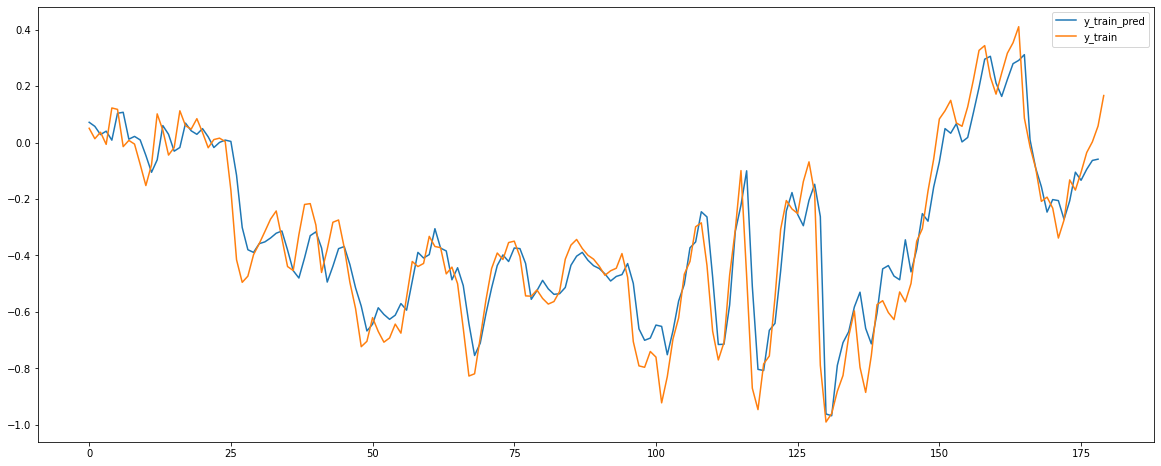

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y_train_pred_LSTM2[1:])),y_train_pred_LSTM2[1:],label ='y_train_pred' )
plt.plot(np.arange(len(y_train2.iloc[:,-1])), y_train2.iloc[:,-1], label ='y_train')
plt.legend(loc='upper right')

In [ ]:
mean_squared_error(y_test_pred_LSTM2 , y_test2.iloc[:,-1])

0.04000054582703986

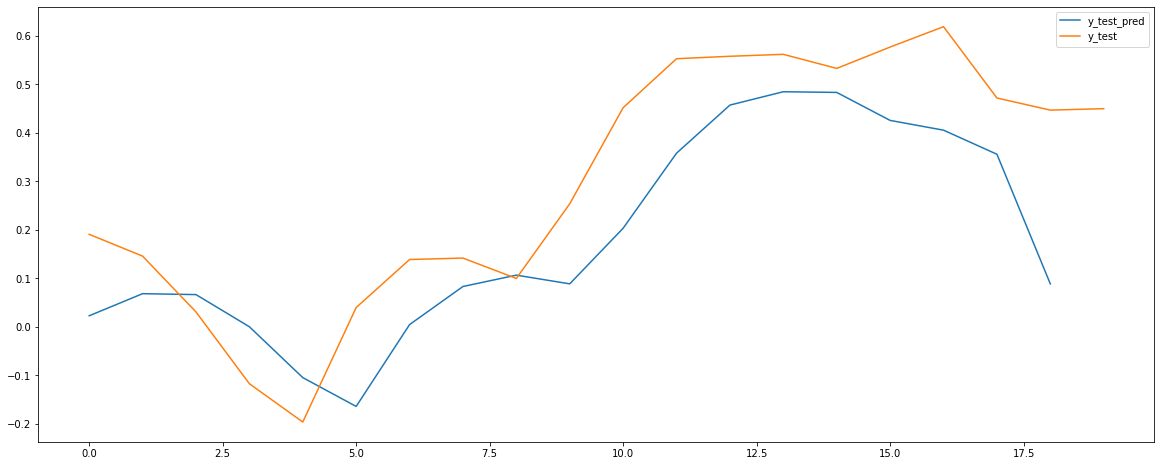

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y_test_pred_LSTM2[1:])),y_test_pred_LSTM2[1:],label ='y_test_pred' )
plt.plot(np.arange(len(y_test2.iloc[:,-1])), y_test2.iloc[:,-1], label ='y_test')
plt.legend(loc='upper right')

##LONG-TERM FORECAST FROM LONG-TERM HISTORY 

In [ ]:
df_new3 = pd.concat([MaxTempScaledValues.shift(37),MaxTempScaledValues.shift(36),MaxTempScaledValues.shift(35),MaxTempScaledValues.shift(34),MaxTempScaledValues.shift(33),MaxTempScaledValues.shift(32),MaxTempScaledValues.shift(31),MaxTempScaledValues.shift(30),MaxTempScaledValues.shift(29),MaxTempScaledValues.shift(28),MaxTempScaledValues.shift(27),MaxTempScaledValues.shift(26),MaxTempScaledValues.shift(25),MaxTempScaledValues.shift(24),MaxTempScaledValues.shift(23),MaxTempScaledValues.shift(22),MaxTempScaledValues.shift(21),MaxTempScaledValues.shift(20),MaxTempScaledValues.shift(19),MaxTempScaledValues.shift(18),MaxTempScaledValues.shift(17),MaxTempScaledValues.shift(16),MaxTempScaledValues.shift(15),MaxTempScaledValues.shift(14),MaxTempScaledValues.shift(13),MaxTempScaledValues.shift(12),MaxTempScaledValues.shift(11),MaxTempScaledValues.shift(10),MaxTempScaledValues.shift(9),MaxTempScaledValues.shift(8),MaxTempScaledValues.shift(7),MaxTempScaledValues.shift(6),MaxTempScaledValues.shift(5),MaxTempScaledValues.shift(4),MaxTempScaledValues.shift(3),MaxTempScaledValues.shift(2),MaxTempScaledValues.shift(1),MaxTempScaledValues], axis=1)
df_new3.columns = ['t-30','t-29','t-28','t-27','t-26','t-25','t-24','t-23','t-22','t-21','t-20','t-19','t-18','t-17','t-16','t-15','t-14','t-13','t-12','t-11','t-10','t-9','t-8','t-7','t-6','t-5','t-4','t-3','t-2','t-1','t','t+1','t+2','t+3','t+4','t+5','t+6','t+7']
df_new3 = df_new3.dropna(how= 'any')
df_new3.head(5)

t-30      t-29      t-28  ...       t+5       t+6       t+7
37 -0.713341 -0.707341 -0.602341  ... -0.980341 -1.105341 -0.982341
38 -0.707341 -0.602341 -0.591341  ... -1.105341 -0.982341 -0.763341
39 -0.602341 -0.591341 -0.666341  ... -0.982341 -0.763341 -0.630341
40 -0.591341 -0.666341 -0.570341  ... -0.763341 -0.630341 -0.628341
41 -0.666341 -0.570341 -0.400341  ... -0.630341 -0.628341 -0.405341

[5 rows x 38 columns]

In [ ]:
df_new3 = df_new3.iloc[:,:]
df_new3.shape

(4099, 38)

In [ ]:
n_points = len(df_new3)
train_points3 = int(9/10*n_points)
X_train3, X_test3 =df_new3.iloc[:train_points3 , [0 , 1 , 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]], df_new3.iloc[train_points3 :, [0 , 1 , 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]]
y_train3, y_test3 =df_new3.iloc[:train_points3: , [30,31,32,33,34,35,36]],  df_new3.iloc[train_points3: , [30,31,32,33,34,35,36]]
print("We have", len(X_train3), "training points and", X_test3.shape[0], "testing points")

We have 3689 training points and 410 testing points


In [ ]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
keras.backend.clear_session()

X_train3 = np.array(X_train3).reshape(X_train3.shape[0],X_train3.shape[1], 1)
X_test3 = np.array(X_test3).reshape(X_test3.shape[0],X_test3.shape[1], 1)
print(X_train3.shape)
print(X_test3.shape)

(3689, 30, 1)
(410, 30, 1)


In [ ]:
model3 = Sequential()
model3.add(LSTM(64,return_sequences=True,activation="relu",input_shape = (X_train3.shape[1],X_train3.shape[2])))
model3.add(LSTM(32,activation="relu"))
model3.add(Dense(1))
model3.compile(loss="mean_squared_error",optimizer = "adam")

In [ ]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epoch = 80

model3.fit(X_train3, y_train3, epochs=nb_epoch)

Epoch 1/80
116/116 [==============================] - 11s 78ms/step - loss: 0.1079
Epoch 2/80
116/116 [==============================] - 9s 79ms/step - loss: 0.0604
Epoch 3/80
116/116 [==============================] - 9s 76ms/step - loss: 0.0556
Epoch 4/80
116/116 [==============================] - 9s 76ms/step - loss: 0.0534
Epoch 5/80
116/116 [==============================] - 9s 78ms/step - loss: 0.0519
Epoch 6/80
116/116 [==============================] - 9s 77ms/step - loss: 0.0517
Epoch 7/80
116/116 [==============================] - 9s 77ms/step - loss: 0.0491
Epoch 8/80
116/116 [==============================] - 9s 76ms/step - loss: 0.0479
Epoch 9/80
116/116 [==============================] - 9s 78ms/step - loss: 0.0465
Epoch 10/80
116/116 [==============================] - 9s 77ms/step - loss: 0.0468
Epoch 11/80
116/116 [==============================] - 9s 77ms/step - loss: 0.0446
Epoch 12/80
116/116 [==============================] - 9s 78ms/step - loss: 0.0484
Epoch 13/80


In [ ]:
y_train_pred_LSTM3 = model3.predict(X_train3)
y_test_pred_LSTM3 = model3.predict(X_test3)

In [ ]:
mean_squared_error(y_train_pred_LSTM3 , y_train3.iloc[:,-1])

0.04178848400069275

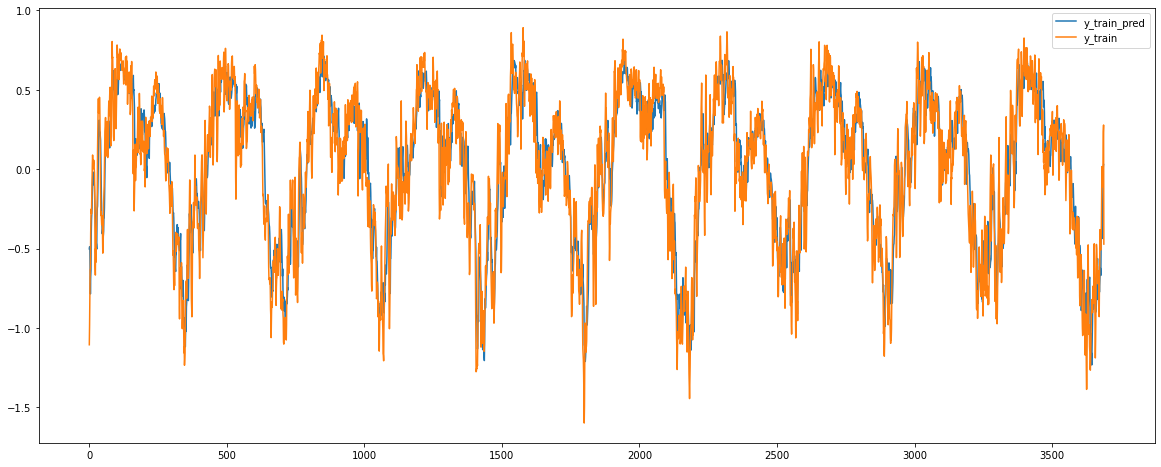

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y_train_pred_LSTM3[1:])),y_train_pred_LSTM3[1:],label ='y_train_pred' )
plt.plot(np.arange(len(y_train3.iloc[:,-1])), y_train3.iloc[:,-1], label ='y_train')
plt.legend(loc='upper right')

In [ ]:
mean_squared_error(y_test_pred_LSTM3 , y_test3.iloc[:,-1])

0.0562293407326888

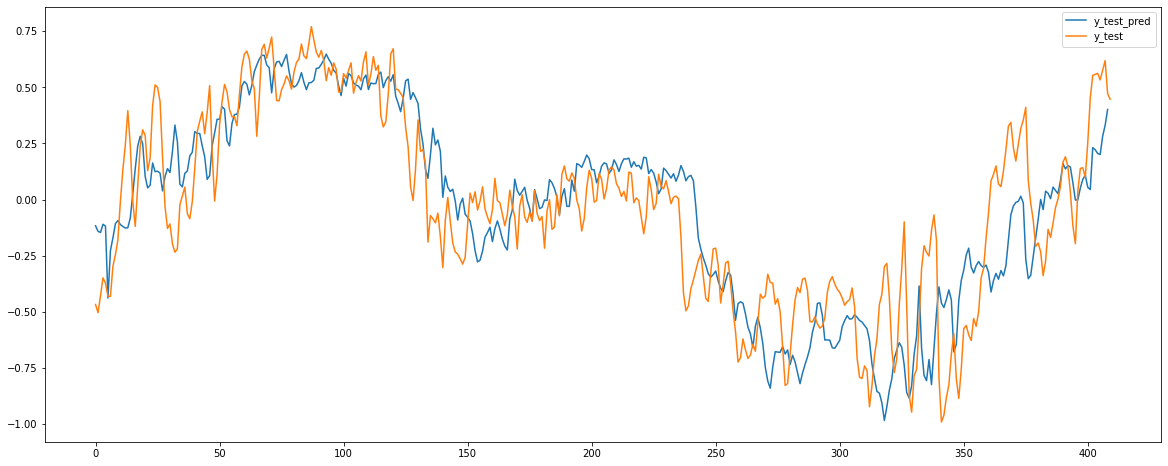

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y_test_pred_LSTM3[1:])),y_test_pred_LSTM3[1:],label ='y_test_pred' )
plt.plot(np.arange(len(y_test3.iloc[:,-1])), y_test3.iloc[:,-1], label ='y_test')
plt.legend(loc='upper right')


# CNN

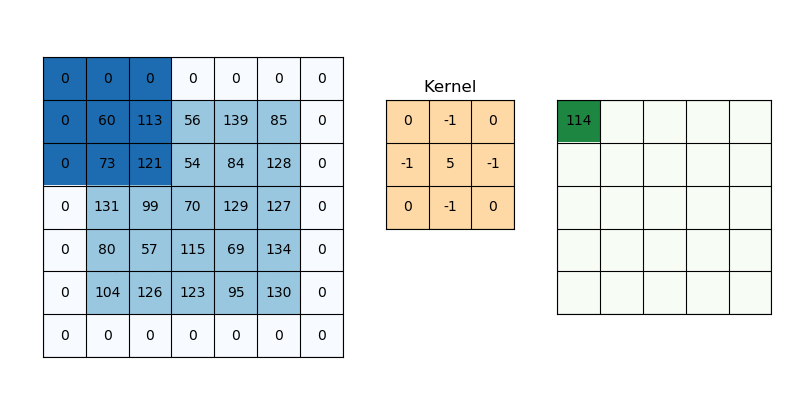

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

###Short Term Forecast with short-term history

In [ ]:
X_train1.shape

(3717, 5, 1)

In [ ]:
# define model
model1_cnn = Sequential()
model1_cnn.add(Conv1D(filters=5, kernel_size=3, activation='relu', input_shape=(X_train1.shape[1], 1)))
model1_cnn.add(MaxPooling1D(pool_size=2))
model1_cnn.add(Flatten())
model1_cnn.add(Dense(50, activation='relu'))
model1_cnn.add(Dense(1))
model1_cnn.compile(optimizer='adam', loss='mse')

In [ ]:
model1_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3, 5)              20        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 5)              0         
_________________________________________________________________
flatten (Flatten)            (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                300       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#X_train1 = X_train.reset_index(drop=True)

In [ ]:
nb_epoch = 40

model1_cnn.fit(X_train1, y_train, epochs=nb_epoch)

Epoch 1/40
117/117 [==============================] - 29s 2ms/step - loss: 0.1629
Epoch 2/40
117/117 [==============================] - 0s 2ms/step - loss: 0.0549
Epoch 3/40
117/117 [==============================] - 0s 2ms/step - loss: 0.0502
Epoch 4/40
117/117 [==============================] - 0s 2ms/step - loss: 0.0467
Epoch 5/40
117/117 [==============================] - 0s 2ms/step - loss: 0.0476
Epoch 6/40
117/117 [==============================] - 0s 2ms/step - loss: 0.0444
Epoch 7/40
117/117 [==============================] - 0s 2ms/step - loss: 0.0441
Epoch 8/40
117/117 [==============================] - 0s 2ms/step - loss: 0.0431
Epoch 9/40
117/117 [==============================] - 0s 2ms/step - loss: 0.0422
Epoch 10/40
117/117 [==============================] - 0s 2ms/step - loss: 0.0416
Epoch 11/40
117/117 [==============================] - 0s 2ms/step - loss: 0.0407
Epoch 12/40
117/117 [==============================] - 0s 2ms/step - loss: 0.0412
Epoch 13/40
117/117 [===

In [ ]:
y_train_predc1 = model1_cnn.predict(X_train1)
y_test_predc1 = model1_cnn.predict(X_test1)

In [ ]:
y_train.iloc[:,-1:]

t+1
6    -0.400341
7    -0.411341
8    -0.339341
9    -0.213341
10   -0.197341
...        ...
3718 -0.062341
3719 -0.100341
3720 -0.110341
3721 -0.030341
3722  0.234659

[3717 rows x 1 columns]

In [ ]:
mean_squared_error(y_train_predc1 , y_train.iloc[:,-1:])

0.04547119298964671

In [ ]:
#y1_train = y_train.values.reshape(1,len(y_train))

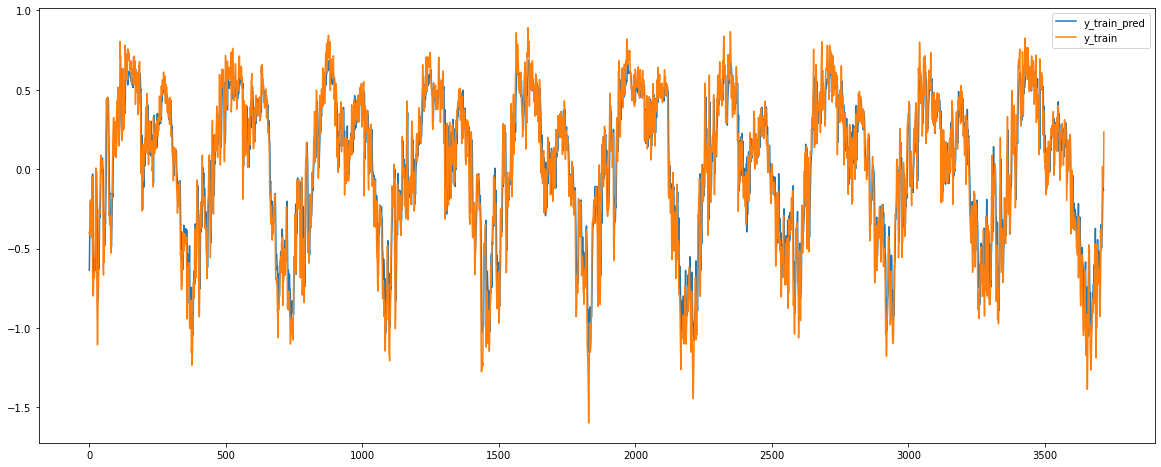

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y_train_predc1[1:])),y_train_predc1[1:],label ='y_train_pred' )
plt.plot(np.arange(len(y_train.iloc[:,-1:])), y_train.iloc[:,-1:], label ='y_train')
plt.legend(loc='upper right')

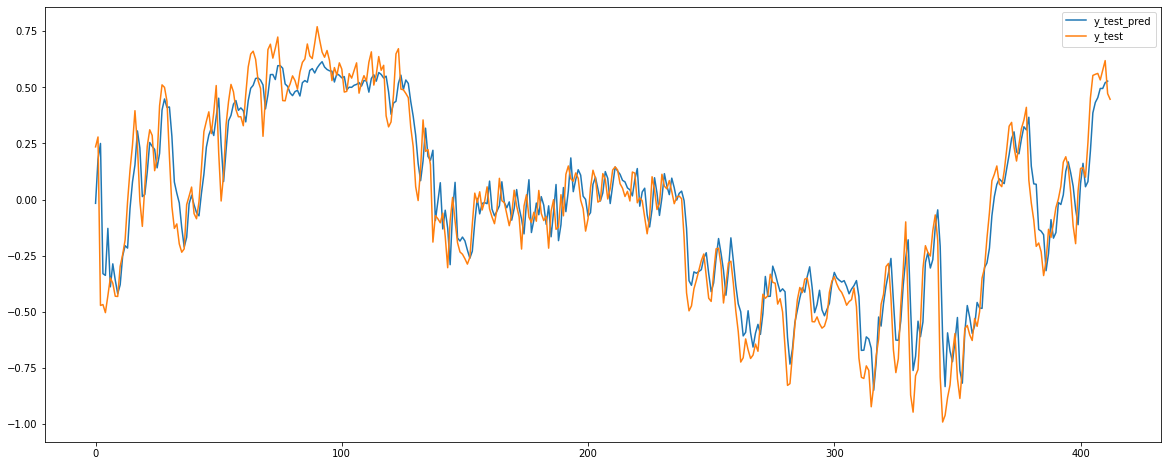

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y_test_predc1[1:])),y_test_predc1[1:],label ='y_test_pred' )
plt.plot(np.arange(len(y_test.iloc[:,-2:-1])), y_test.iloc[:,-2:-1], label ='y_test')
plt.legend(loc='best')

In [ ]:
model2_cnn = Sequential()
model2_cnn.add(Conv1D(filters=15, kernel_size=3, activation='relu', input_shape=(X_train2.shape[1], 1)))
model2_cnn.add(MaxPooling1D(pool_size=3))
model2_cnn.add(Flatten())
model2_cnn.add(Dense(50, activation='relu'))
model2_cnn.add(Dense(1))
model2_cnn.compile(optimizer='adam', loss='mse')

In [ ]:
model2_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 12, 15)            60        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 15)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 3,161
Trainable params: 3,161
Non-trainable params: 0
_________________________________________________________________


Calculate the predicted values

In [ ]:
nb_epoch = 50

model2_cnn.fit(X_train2, y_train2, epochs=nb_epoch)

Epoch 1/50
6/6 [==============================] - 1s 7ms/step - loss: 0.2520
Epoch 2/50
6/6 [==============================] - 0s 2ms/step - loss: 0.1398
Epoch 3/50
6/6 [==============================] - 0s 2ms/step - loss: 0.0957
Epoch 4/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0636
Epoch 5/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0566
Epoch 6/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0548
Epoch 7/50
6/6 [==============================] - 0s 2ms/step - loss: 0.0487
Epoch 8/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0439
Epoch 9/50
6/6 [==============================] - 0s 2ms/step - loss: 0.0388
Epoch 10/50
6/6 [==============================] - 0s 2ms/step - loss: 0.0435
Epoch 11/50
6/6 [==============================] - 0s 2ms/step - loss: 0.0404
Epoch 12/50
6/6 [==============================] - 0s 2ms/step - loss: 0.0407
Epoch 13/50
6/6 [==============================] - 0s 2ms/step - loss: 0.

In [ ]:
y_train_predc2 = model2_cnn.predict(X_train2)
y_test_predc2 = model2_cnn.predict(X_test2)

In [ ]:
mean_squared_error(y_train_predc2 , y_train2.iloc[:,-1:])

0.026922753909797356

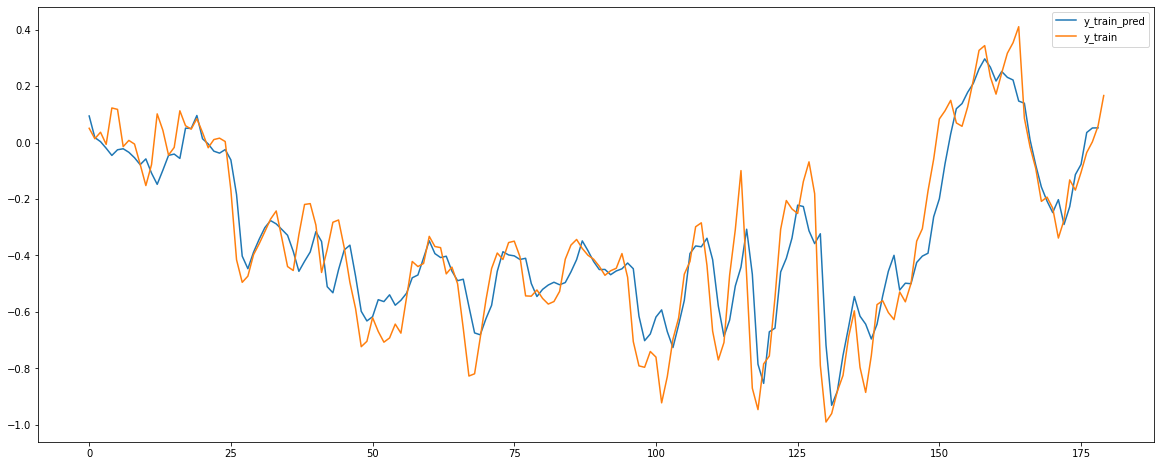

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y_train_predc2[1:])),y_train_predc2[1:],label ='y_train_pred' )
plt.plot(np.arange(len(y_train2.iloc[:,-1:])), y_train2.iloc[:,-1:], label ='y_train')
plt.legend(loc='upper right')

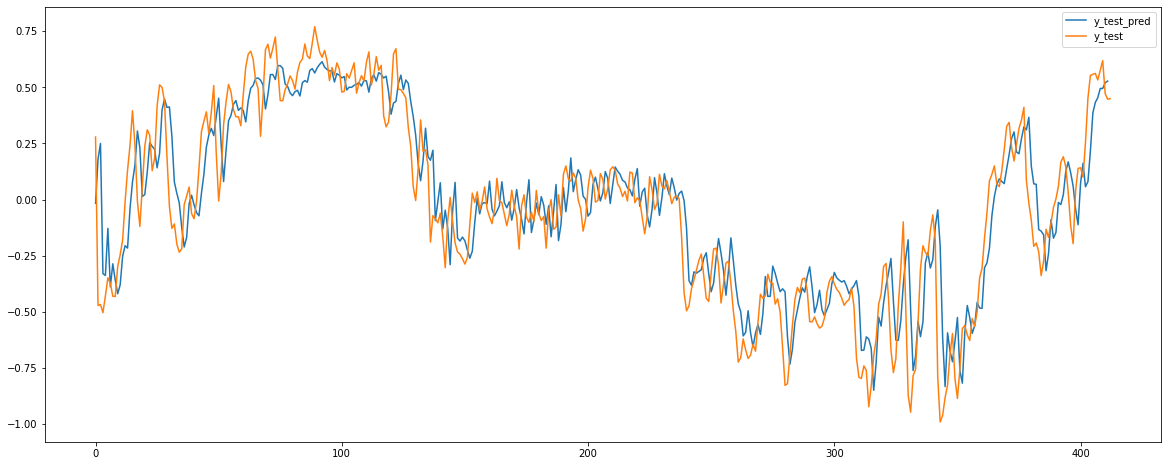

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y_test_predc1[1:])),y_test_predc1[1:],label ='y_test_pred' )
plt.plot(np.arange(len(y_test.iloc[:,-1:])), y_test.iloc[:,-1:], label ='y_test')
plt.legend(loc='best')

In [ ]:
#Model3

In [ ]:
model3_cnn = Sequential()
model3_cnn.add(Conv1D(filters=15, kernel_size=3, activation='relu', input_shape=(X_train3.shape[1], 1)))
model3_cnn.add(MaxPooling1D(pool_size=3))
model3_cnn.add(Flatten())
model3_cnn.add(Dense(64, activation='relu'))
model3_cnn.add(Dense(1))
model3_cnn.compile(optimizer='adam', loss='mse')

In [ ]:
model3_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 28, 15)            60        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 15)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 135)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8704      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 8,829
Trainable params: 8,829
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epoch = 100

model3_cnn.fit(X_train3, y_train3, epochs=nb_epoch)

Epoch 1/100
116/116 [==============================] - 1s 2ms/step - loss: 0.0986
Epoch 2/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0609
Epoch 3/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0566
Epoch 4/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0559
Epoch 5/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0543
Epoch 6/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0542
Epoch 7/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0519
Epoch 8/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0500
Epoch 9/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0507
Epoch 10/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0483
Epoch 11/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0477
Epoch 12/100
116/116 [==============================] - 0s 2ms/step - loss: 0.0491
Epoch 13/100


In [ ]:
y_train_predc3 = model3_cnn.predict(X_train3)
y_test_predc3 = model3_cnn.predict(X_test3)

In [ ]:
mean_squared_error(y_train_predc3 , y_train3.iloc[:,-1:])

0.03614181538841213

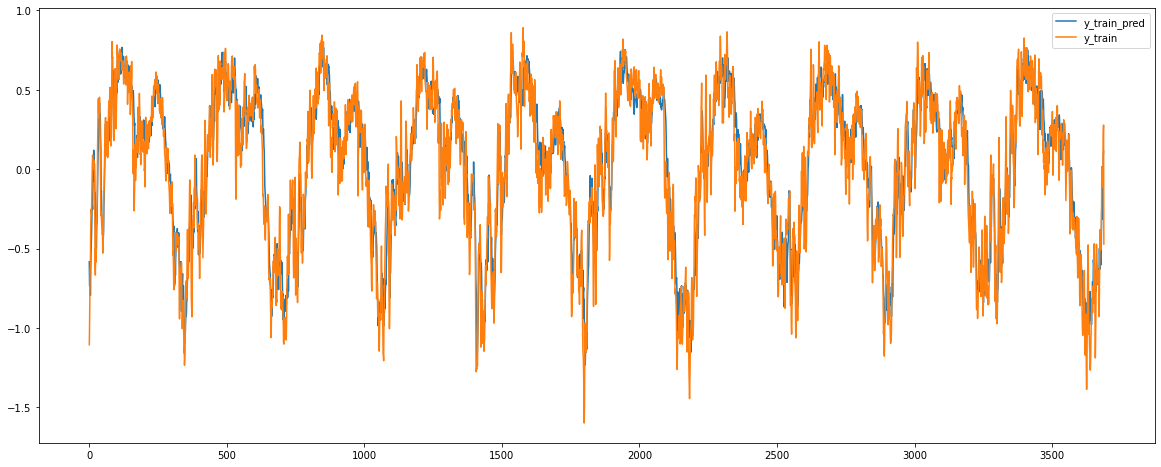

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y_train_predc3[1:])),y_train_predc3[1:],label ='y_train_pred' )
plt.plot(np.arange(len(y_train3.iloc[:,-1:])), y_train3.iloc[:,-1:], label ='y_train')
plt.legend(loc='upper right')

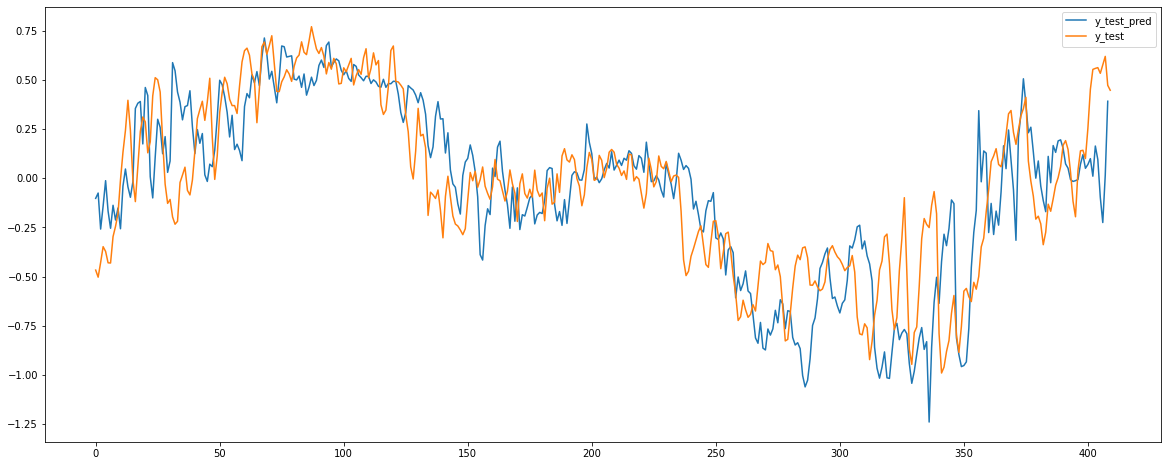

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y_test_predc3[1:])),y_test_predc3[1:],label ='y_test_pred' )
plt.plot(np.arange(len(y_test3.iloc[:,-1:])), y_test3.iloc[:,-1:], label ='y_test')
plt.legend(loc='best')

PRECIPITATION

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math

import tensorflow as tf
#tf.set_random_seed(1234)

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from sklearn.metrics import mean_squared_error

In [ ]:
data_sudan=pd.read_csv('https://raw.githubusercontent.com/WangariKimotho/DeepL_Climate/main/Khartoum_data.csv')
data_sudan.tail()

LAT       LON  YEAR  MO  ...     T2M  PRECTOT    QV2M    RH2M
4133  15.55131  32.53211  2021   4  ...   33.65     0.00    3.90   11.49
4134  15.55131  32.53211  2021   4  ...   33.40     0.08    6.61   19.68
4135  15.55131  32.53211  2021   4  ...   33.43     0.01    7.99   23.76
4136  15.55131  32.53211  2021   4  ... -999.00  -999.00 -999.00 -999.00
4137  15.55131  32.53211  2021   4  ... -999.00  -999.00 -999.00 -999.00

[5 rows x 13 columns]

# Preprossecing Data

In [ ]:
data_sudan=data_sudan.drop([4136,4137],axis=0)

In [ ]:
data_sudan.tail(2)

LAT       LON  YEAR  MO  DY  ...  T2M_MIN    T2M  PRECTOT  QV2M   RH2M
4134  15.55131  32.53211  2021   4  27  ...    26.25  33.40     0.08  6.61  19.68
4135  15.55131  32.53211  2021   4  28  ...    26.62  33.43     0.01  7.99  23.76

[2 rows x 13 columns]

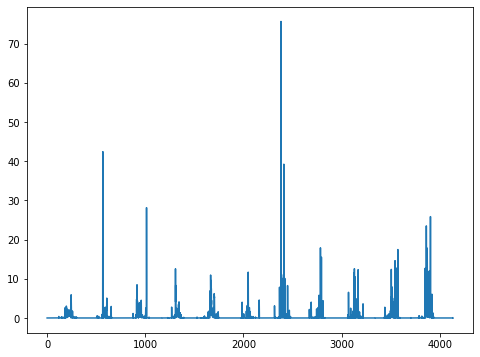

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(data_sudan['PRECTOT'])

In [ ]:
colors1 =['b', 'g', 'r', 'c', 'm', 'y' ,  
          'aqua' , 'antiquewhite' , 'cornflowerblue'  , 
          'forestgreen'  , 'mediumslateblue'   ,'tan']
len(colors1)

12

In [ ]:
def YearPlots(YEAR):
    plt.figure(figsize=(14, 10))
    plt.title('Monthly Temperature ')
    labels = ['Jan' , 'Feb' , 'Mar' , 'Apr' , 'May' , 
          'Jun' , 'Jul' , 'Aug' , 'Sept' , 'Oct' , 'Nov' , 'Dec']
    df_year = data_sudan[ data_sudan['YEAR'] == YEAR ]
    for month in range(1, 13):
    
        plt.subplot(3, 4, month)
        plt.plot(df_year[df_year['MO'] == month]['PRECTOT']  , colors1[month-1])
        plt.xlabel(labels[month-1])
        #return 

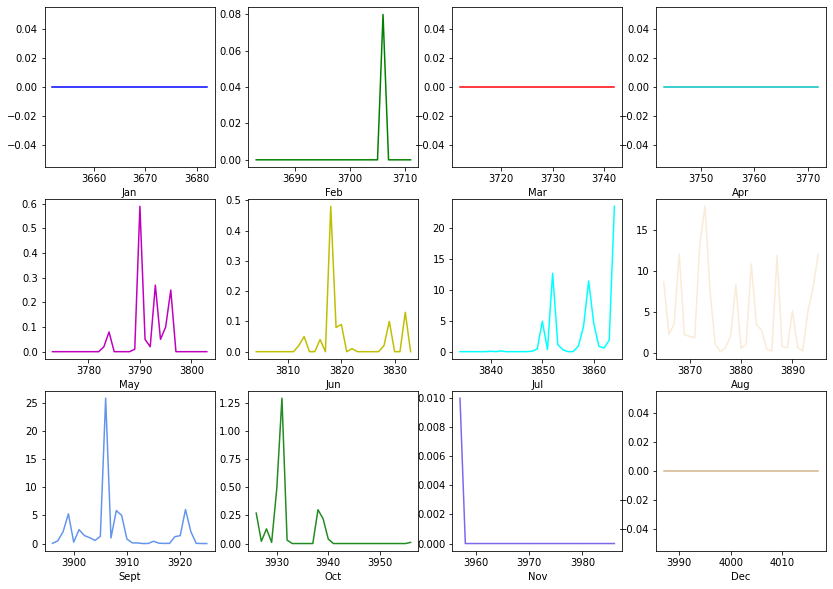

In [ ]:
YearPlots(2020)

In [ ]:
def YearPlots(n):
    plt.figure(figsize=(14, 10))
    plt.title('Annual precipatation  ')
    labels = ['2010' , '2011' , '2012' , '2013' , '2014' , 
          '2015' , '2016' , '2017' , '2018' , '2019' , '2010' , '2021']
    Annual=[2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]
    for i in range(1, n):
       df_year = data_sudan[ data_sudan['YEAR'] == Annual[i-1]]
       plt.subplot(3, 4, i)
       plt.plot(df_year['PRECTOT'], colors1[i-1])
       plt.xlabel(labels[i-1])
        #return 

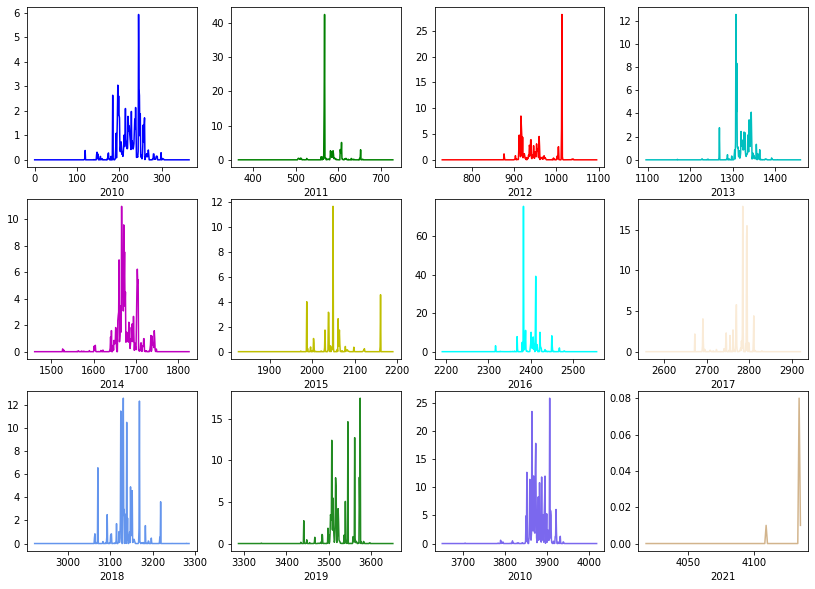

In [ ]:
YearPlots(13)

# standization of Data

In [ ]:
data_sudan1=data_sudan[data_sudan['PRECTOT']>0]
data_sudan1

LAT       LON  YEAR  MO  DY  ...  T2M_MIN    T2M  PRECTOT  QV2M   RH2M
117   15.55131  32.53211  2010   4  28  ...    23.65  33.43     0.02  3.48  10.36
118   15.55131  32.53211  2010   4  29  ...    25.55  35.59     0.02  5.72  15.06
119   15.55131  32.53211  2010   4  30  ...    30.00  36.98     0.38  8.55  20.80
139   15.55131  32.53211  2010   5  20  ...    27.33  35.95     0.01  7.71  19.92
142   15.55131  32.53211  2010   5  23  ...    25.84  34.62     0.01  6.49  18.06
...        ...       ...   ...  ..  ..  ...      ...    ...      ...   ...    ...
3956  15.55131  32.53211  2020  10  31  ...    22.28  29.29     0.01  7.60  28.68
3957  15.55131  32.53211  2020  11   1  ...    21.72  28.75     0.01  6.89  26.88
4109  15.55131  32.53211  2021   4   2  ...    21.17  27.61     0.01  3.03  12.68
4134  15.55131  32.53211  2021   4  27  ...    26.25  33.40     0.08  6.61  19.68
4135  15.55131  32.53211  2021   4  28  ...    26.62  33.43     0.01  7.99  23.76

[1136 rows x 13 columns]

In [ ]:
def ReScaleAroundZero(data, a):
    data_avg = data.mean()
    scaled_data = a*(data - data_avg)
    return scaled_data


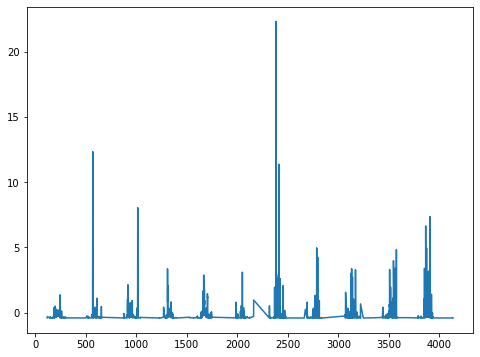

In [ ]:
Maxpreci_Rescaled  = ReScaleAroundZero(data_sudan1['PRECTOT'] , 0.3)
plt.figure(figsize=(8,6))
plt.plot(Maxpreci_Rescaled )

In [ ]:
def ReScaleAroundZeroPlot(a):
    plt.figure(figsize=(8,6))
    data_avg = data_sudan['PRECTOT'].mean()
    scaled_data = a*(data_sudan['PRECTOT'] - data_avg)
    return plt.plot(scaled_data)

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual

In [ ]:
interact(ReScaleAroundZeroPlot ,  a=(0,1, 0.1) )

interactive(children=(FloatSlider(value=0.0, description='a', max=1.0), Output()), _dom_classes=('widget-inter…

<function __main__.ReScaleAroundZeroPlot>

#Splitting and training the model

#LSTM

# Short pass information To predict Short time step

In [ ]:

sinValues = pd.DataFrame(Maxpreci_Rescaled.values)

df_new = pd.concat([sinValues.shift(6),sinValues.shift(5),sinValues.shift(4),sinValues.shift(3),sinValues.shift(2), sinValues.shift(1),sinValues], axis=1)
df_new.columns = ['t-5','t-4','t-3','t-2','t-1' ,'t','t+1']
df_new = df_new.dropna(how= 'any')
df_new.head(5)

t-5       t-4       t-3       t-2       t-1         t       t+1
6  -0.395216 -0.395216 -0.287216 -0.398216 -0.398216 -0.338216 -0.308216
7  -0.395216 -0.287216 -0.398216 -0.398216 -0.338216 -0.308216 -0.383216
8  -0.287216 -0.398216 -0.398216 -0.338216 -0.308216 -0.383216 -0.329216
9  -0.398216 -0.398216 -0.338216 -0.308216 -0.383216 -0.329216 -0.398216
10 -0.398216 -0.338216 -0.308216 -0.383216 -0.329216 -0.398216 -0.395216

In [ ]:
n_points = len(df_new)
train_points = int(9/10*n_points)+1
X_train, X_test =df_new.iloc[:train_points , [0 , 1 , 2,3,4]], df_new.iloc[train_points :, [0 , 1 , 2,3,4]]
y_train, y_test =df_new.iloc[:train_points: , 5],  df_new.iloc[train_points: , 5]
print("We have", len(X_train), "training points and", X_test.shape[0], "testing points")

We have 1018 training points and 112 testing points


In [ ]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
keras.backend.clear_session()

X_train = np.array(X_train).reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0],X_test.shape[1], 1)
print(X_train.shape)
print(X_test.shape)

(1018, 5, 1)
(112, 5, 1)


In [ ]:
model1 = Sequential()
model1.add(LSTM(21,return_sequences=True,activation="relu",input_shape = (X_train.shape[1],X_train.shape[2])))
model1.add(LSTM(21,activation="relu"))
model1.add(Dense(1))
model1.compile(loss="mean_squared_error",optimizer = "adam")
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 21)             1932      
_________________________________________________________________
lstm_1 (LSTM)                (None, 21)                3612      
_________________________________________________________________
dense (Dense)                (None, 1)                 22        
Total params: 5,566
Trainable params: 5,566
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epoch = 150

model1.fit(X_train, y_train, epochs=nb_epoch)

Epoch 1/150
32/32 [==============================] - 3s 16ms/step - loss: 1.6970
Epoch 2/150
32/32 [==============================] - 1s 17ms/step - loss: 0.6760
Epoch 3/150
32/32 [==============================] - 1s 16ms/step - loss: 1.3976
Epoch 4/150
32/32 [==============================] - 1s 16ms/step - loss: 0.9517
Epoch 5/150
32/32 [==============================] - 1s 17ms/step - loss: 1.2613
Epoch 6/150
32/32 [==============================] - 1s 17ms/step - loss: 1.2703
Epoch 7/150
32/32 [==============================] - 1s 16ms/step - loss: 1.0688
Epoch 8/150
32/32 [==============================] - 1s 17ms/step - loss: 0.8060
Epoch 9/150
32/32 [==============================] - 1s 16ms/step - loss: 0.7720
Epoch 10/150
32/32 [==============================] - 1s 17ms/step - loss: 1.4014
Epoch 11/150
32/32 [==============================] - 1s 16ms/step - loss: 0.9141
Epoch 12/150
32/32 [==============================] - 1s 17ms/step - loss: 0.5736
Epoch 13/150
32/32 [=====

In [ ]:
y_train_pred_LSTM1 = model1.predict(X_train)
y_test_pred_LSTM1 = model1.predict(X_test)

In [ ]:
mean_squared_error(y_train_pred_LSTM1, y_train)

0.8651154001154103

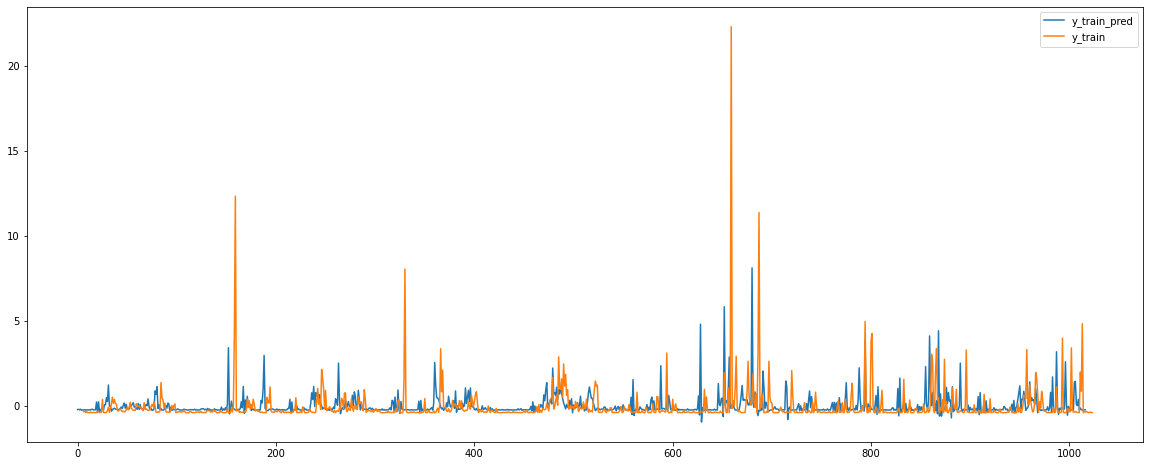

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_train_pred_LSTM1[1:] , label ='y_train_pred')
plt.plot(y_train , label ='y_train')
plt.legend(loc='upper right')

In [ ]:
y_test_pred_LSTM1.shape

(112, 1)

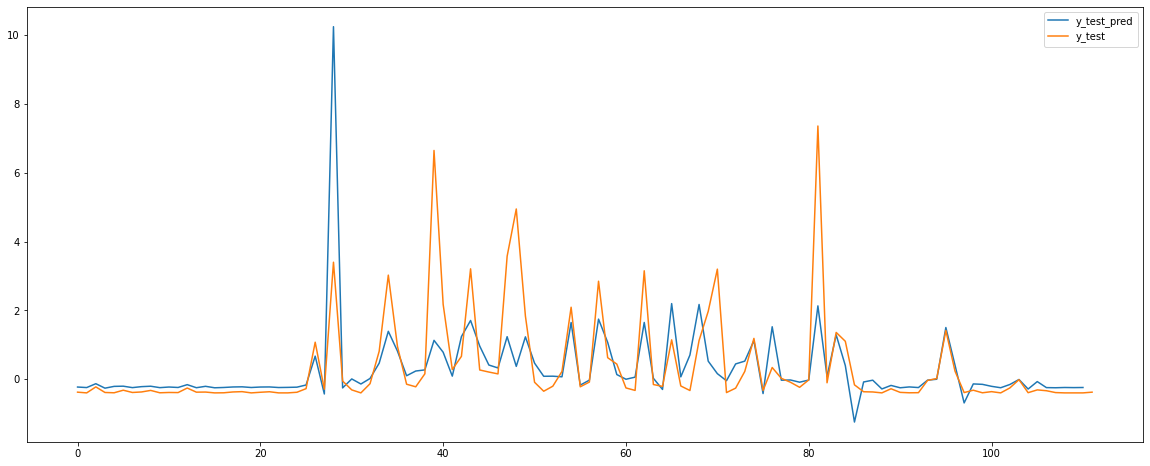

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_test_pred_LSTM1[1:],label ='y_test_pred' )
plt.plot(np.array(y_test) , label ='y_test')
plt.legend(loc='best')

# Long pass information To predict Short time step

In [ ]:
sinValues = pd.DataFrame(Maxpreci_Rescaled.values)

df_new1 = pd.concat([sinValues.shift(15),sinValues.shift(14),sinValues.shift(13),sinValues.shift(12),sinValues.shift(11),sinValues.shift(10),sinValues.shift(9),sinValues.shift(8),sinValues.shift(7),sinValues.shift(6),sinValues.shift(5),sinValues.shift(4),sinValues.shift(3),sinValues.shift(2), sinValues.shift(1),sinValues], axis=1)
df_new1.columns = ['t-14','t-13','t-12','t-11','t-10','t-9','t-8','t-7','t-6','t-5','t-4','t-3','t-2','t-1','t','t+1']
df_new1 = df_new1.dropna(how= 'any')
df_new1.head(5)

t-14      t-13      t-12  ...       t-1         t       t+1
15 -0.395216 -0.395216 -0.287216  ... -0.398216 -0.395216 -0.386216
16 -0.395216 -0.287216 -0.398216  ... -0.395216 -0.386216 -0.398216
17 -0.287216 -0.398216 -0.398216  ... -0.386216 -0.398216 -0.395216
18 -0.398216 -0.398216 -0.338216  ... -0.398216 -0.395216 -0.383216
19 -0.398216 -0.338216 -0.308216  ... -0.395216 -0.383216 -0.332216

[5 rows x 16 columns]

In [ ]:
df_new1 = df_new1.iloc[:,:]

In [ ]:
n_points = len(df_new1)
train_points = int(9/10*n_points)
X_train1, X_test1 =df_new1.iloc[:train_points , [0 , 1 , 2, 3, 4,5,6,7,8,9,10,11,12,13]], df_new1.iloc[train_points :, [0 , 1 , 2, 3, 4,5,6,7,8,9,10,11,12,13]]
y_train1, y_test1 =df_new1.iloc[:train_points: , [15]],  df_new1.iloc[train_points: , [15]]
print("We have", len(X_train1), "training points and", X_test1.shape[0], "testing points")

We have 1008 training points and 113 testing points


In [ ]:
y_train1

t+1
15   -0.386216
16   -0.398216
17   -0.395216
18   -0.383216
19   -0.332216
...        ...
1018 -0.398216
1019 -0.377216
1020 -0.374216
1021 -0.377216
1022 -0.395216

[1008 rows x 1 columns]

In [ ]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
keras.backend.clear_session()

X_train1 = np.array(X_train1).reshape(X_train1.shape[0],X_train1.shape[1], 1)
X_test1 = np.array(X_test1).reshape(X_test1.shape[0],X_test1.shape[1], 1)
print(X_train1.shape)
print(X_test1.shape)

(1008, 14, 1)
(113, 14, 1)


In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(X_train1.shape[1], X_train1.shape[2]))) #input_shape takes time steps and features
#model.add(LSTM(10))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epoch = 100

model.fit(X_train1, y_train1, epochs=nb_epoch)

Epoch 1/100
32/32 [==============================] - 1s 4ms/step - loss: 0.9976
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9021
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7573
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8889
Epoch 5/100
32/32 [==============================] - 0s 4ms/step - loss: 1.0435
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8950
Epoch 7/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8136
Epoch 8/100
32/32 [==============================] - 0s 4ms/step - loss: 1.8420
Epoch 9/100
32/32 [==============================] - 0s 4ms/step - loss: 0.9000
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 1.3675
Epoch 11/100
32/32 [==============================] - 0s 4ms/step - loss: 1.4464
Epoch 12/100
32/32 [==============================] - 0s 3ms/step - loss: 1.3693
Epoch 13/100
32/32 [=================

In [ ]:
y_train_pred_LSTM2 = model.predict(X_train1)
y_test_pred_LSTM2 = model.predict(X_test1)

In [ ]:
y_train_pred_LSTM2


array([[-0.2393479 ],
       [-0.2420963 ],
       [-0.24243176],
       ...,
       [-0.0740229 ],
       [-0.10392799],
       [-0.13008556]], dtype=float32)

In [ ]:
mean_squared_error(y_train_pred_LSTM2, y_train1.iloc[:,-1:])

1.2349865704053786

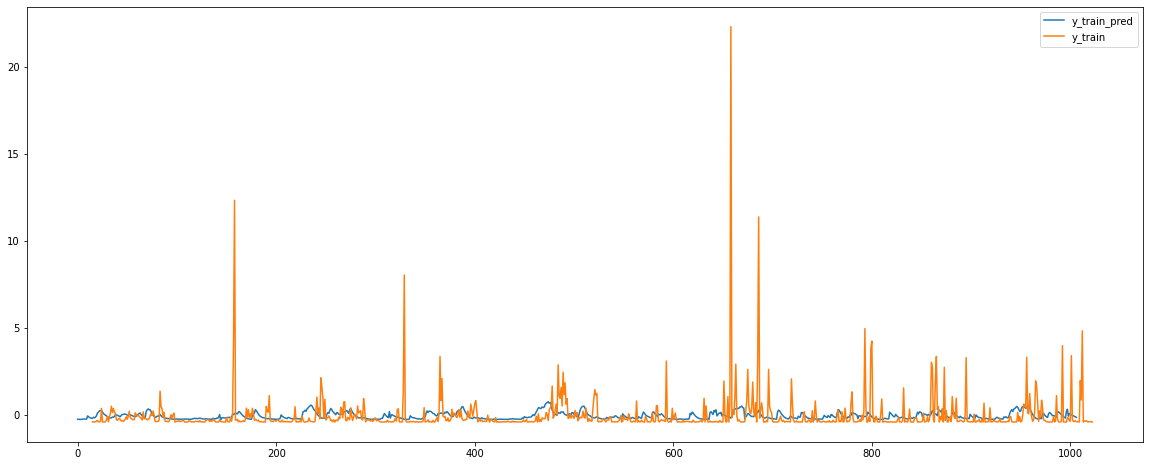

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_train_pred_LSTM2[1:] , label ='y_train_pred')
plt.plot(y_train1 , label ='y_train')
plt.legend(loc='upper right')

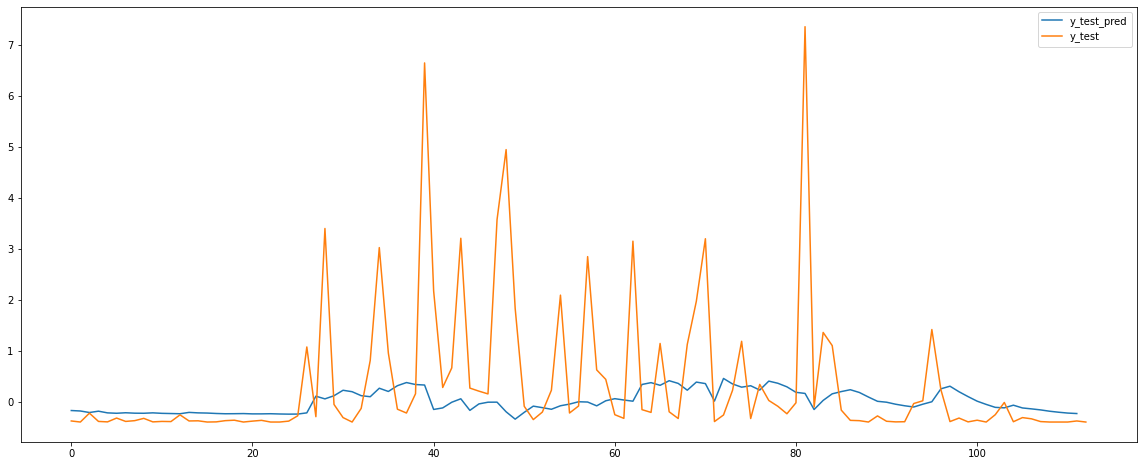

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_test_pred_LSTM2[1:],label ='y_test_pred' )
plt.plot(np.array(y_test1) , label ='y_test')
plt.legend(loc='best')

#Long pass information To predict Long time step

In [ ]:
sinValues = pd.DataFrame(Maxpreci_Rescaled.values)

df_new2 = pd.concat([sinValues.shift(20),sinValues.shift(19),sinValues.shift(18),sinValues.shift(17),sinValues.shift(15),sinValues.shift(14),sinValues.shift(13),sinValues.shift(12),sinValues.shift(11),sinValues.shift(10),sinValues.shift(9),sinValues.shift(8),sinValues.shift(7),sinValues.shift(6),sinValues.shift(5),sinValues.shift(4),sinValues.shift(3),sinValues.shift(2), sinValues.shift(1),sinValues], axis=1)
df_new2.columns = ['t-16','t-15','t-14','t-13','t-12','t-11','t-10','t-9','t-8','t-7','t-6','t-5','t-4','t-3','t-2','t-1','t','t+1','t+2','t+3']
df_new2 = df_new2.dropna(how= 'any')
df_new2.head(5)

t-16      t-15      t-14  ...       t+1       t+2       t+3
20 -0.395216 -0.395216 -0.287216  ... -0.383216 -0.332216 -0.317216
21 -0.395216 -0.287216 -0.398216  ... -0.332216 -0.317216 -0.392216
22 -0.287216 -0.398216 -0.398216  ... -0.317216 -0.392216 -0.389216
23 -0.398216 -0.398216 -0.338216  ... -0.392216 -0.389216 -0.359216
24 -0.398216 -0.338216 -0.308216  ... -0.389216 -0.359216  0.387784

[5 rows x 20 columns]

In [ ]:
n_points = len(df_new2)
train_points = int(9/10*n_points)
X_train1, X_test1 =df_new2.iloc[:train_points , [0 , 1 , 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]], df_new2.iloc[train_points :, [0 , 1 , 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]]
y_train1, y_test1 =df_new2.iloc[:train_points: , [19]],  df_new2.iloc[train_points: , [19]]
print("We have", len(X_train1), "training points and", X_test1.shape[0], "testing points")

We have 1004 training points and 112 testing points


In [ ]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
keras.backend.clear_session()

X_train1 = np.array(X_train1).reshape(X_train1.shape[0],X_train1.shape[1], 1)
X_test1 = np.array(X_test1).reshape(X_test1.shape[0],X_test1.shape[1], 1)
print(X_train1.shape)
print(X_test1.shape)

(1004, 20, 1)
(112, 20, 1)


In [ ]:
model2 = Sequential()
model2.add(LSTM(4, input_shape=(X_train1.shape[1], X_train1.shape[2]))) #input_shape takes time steps and features
#model2.add(LSTM(10))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epoch = 100

model2.fit(X_train1, y_train1, epochs=nb_epoch)

Epoch 1/100
32/32 [==============================] - 1s 3ms/step - loss: 0.9557
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 1.0603
Epoch 3/100
32/32 [==============================] - 0s 4ms/step - loss: 1.1239
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9368
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 2.3181
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8685
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 1.2681
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 1.1198
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9522
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 1.2354
Epoch 11/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5585
Epoch 12/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9783
Epoch 13/100
32/32 [=================

In [ ]:
y_train_pred_LSTM3 = model2.predict(X_train1)
y_test_pred_LSTM3 = model2.predict(X_test1)

In [ ]:
mean_squared_error(y_train_pred_LSTM3, y_train1.iloc[:,-1:])

0.3803715622876042

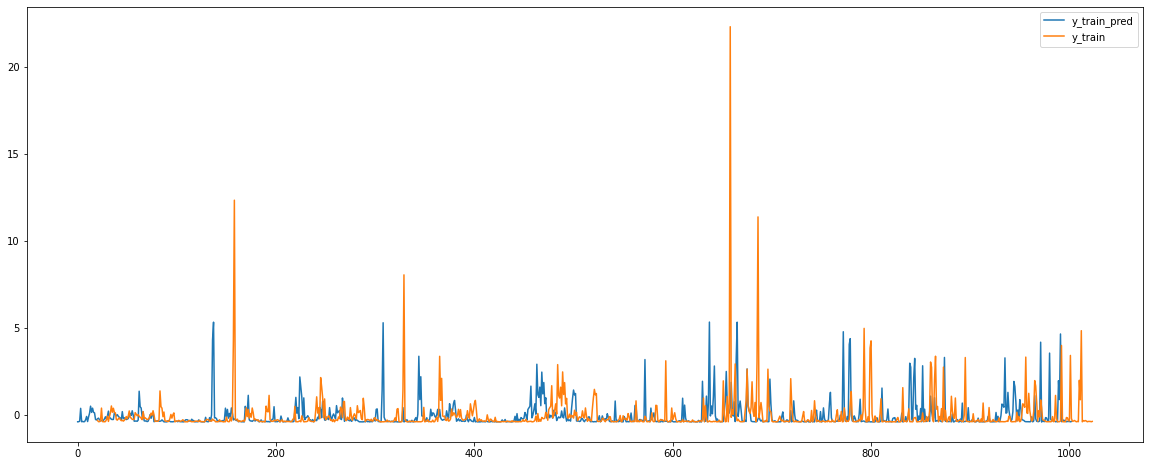

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_train_pred_LSTM3[1:] , label ='y_train_pred')
plt.plot(y_train1 , label ='y_train')
plt.legend(loc='upper right')

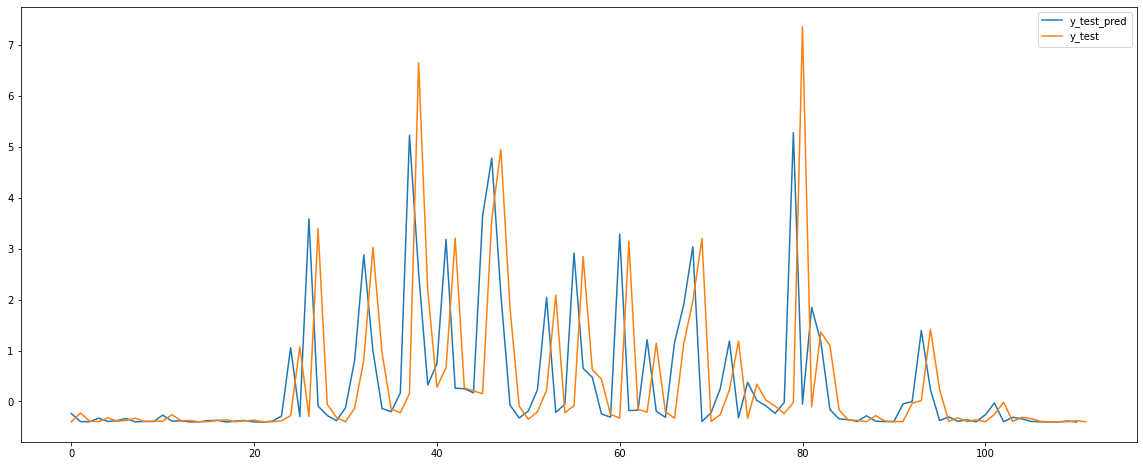

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_test_pred_LSTM3[1:],label ='y_test_pred' )
plt.plot(np.array(y_test1) , label ='y_test')
plt.legend(loc='best')

#CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
# define model
model1_cnn = Sequential()
model1_cnn.add(Conv1D(filters=5, kernel_size=3, activation='relu', input_shape=(X_train1.shape[1], 1)))
model1_cnn.add(MaxPooling1D(pool_size=2))
model1_cnn.add(Flatten())
model1_cnn.add(Dense(50, activation='relu'))
model1_cnn.add(Dense(1))
model1_cnn.compile(optimizer='adam', loss='mse')
model1_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 5)             20        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 5)              0         
_________________________________________________________________
flatten (Flatten)            (None, 45)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2300      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 2,371
Trainable params: 2,371
Non-trainable params: 0
_________________________________________________________________


#Short Term Forecast with short-term history

In [ ]:
# define model
model1_cnn = Sequential()
model1_cnn.add(Conv1D(filters=5, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model1_cnn.add(MaxPooling1D(pool_size=2))
model1_cnn.add(Flatten())
model1_cnn.add(Dense(50, activation='relu'))
model1_cnn.add(Dense(1))
model1_cnn.compile(optimizer='adam', loss='mse')
model1_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 3, 5)              20        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 5)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                300       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epoch = 40

model1_cnn.fit(X_train, y_train, epochs=nb_epoch)

Epoch 1/40
32/32 [==============================] - 0s 3ms/step - loss: 0.8852
Epoch 2/40
32/32 [==============================] - 0s 2ms/step - loss: 0.8348
Epoch 3/40
32/32 [==============================] - 0s 2ms/step - loss: 1.0740
Epoch 4/40
32/32 [==============================] - 0s 2ms/step - loss: 0.8824
Epoch 5/40
32/32 [==============================] - 0s 2ms/step - loss: 0.9533
Epoch 6/40
32/32 [==============================] - 0s 2ms/step - loss: 2.7255
Epoch 7/40
32/32 [==============================] - 0s 3ms/step - loss: 1.0368
Epoch 8/40
32/32 [==============================] - 0s 2ms/step - loss: 0.9317
Epoch 9/40
32/32 [==============================] - 0s 2ms/step - loss: 1.1609
Epoch 10/40
32/32 [==============================] - 0s 2ms/step - loss: 1.3959
Epoch 11/40
32/32 [==============================] - 0s 2ms/step - loss: 0.8739
Epoch 12/40
32/32 [==============================] - 0s 2ms/step - loss: 0.8127
Epoch 13/40
32/32 [==============================

In [ ]:
y_train_predc1_cnn = model1_cnn.predict(X_train)
y_test_predc1_cnn = model1_cnn.predict(X_test)

In [ ]:
mean_squared_error(y_train_predc1_cnn , y_train)

1.2147359882952873

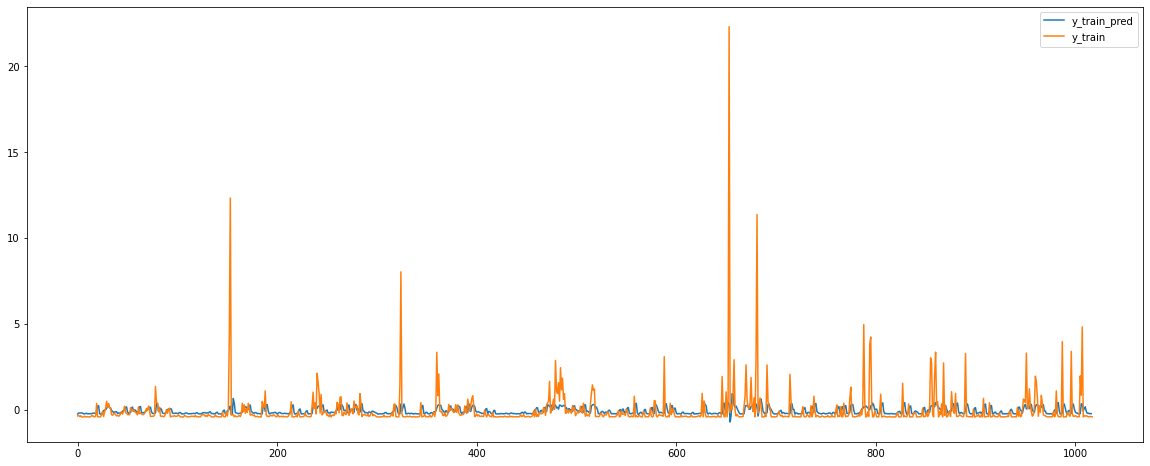

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y_train_predc1_cnn[1:])),y_train_predc1_cnn[1:],label ='y_train_pred' )
plt.plot(np.arange(len(y_train)), y_train, label ='y_train')
plt.legend(loc='best')

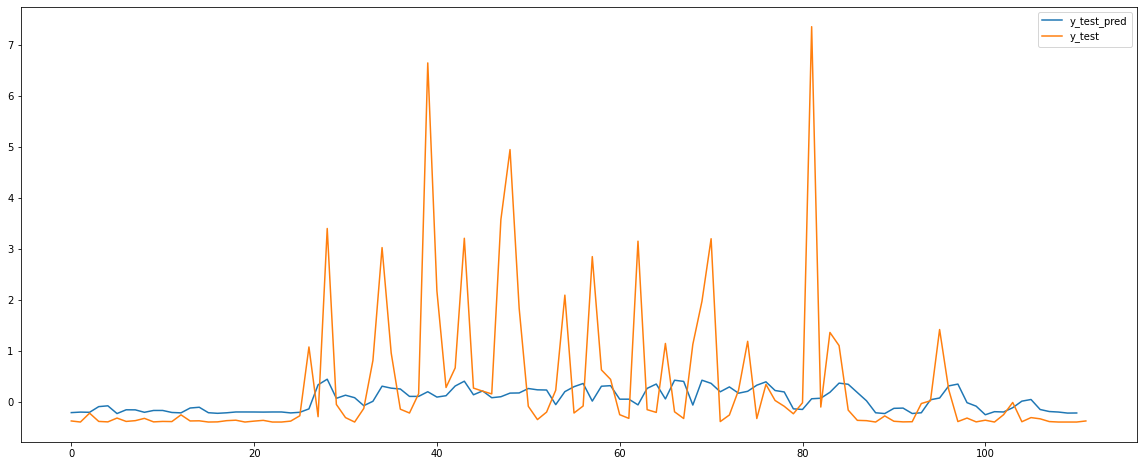

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y_test_predc1_cnn[1:])),y_test_predc1_cnn[1:],label ='y_test_pred' )
plt.plot(np.arange(len(y_test)), y_test, label ='y_test')
plt.legend(loc='best')

# Short term forecast from long-term history

In [ ]:
model2_cnn = Sequential()
model2_cnn.add(Conv1D(filters=15, kernel_size=3, activation='relu', input_shape=(X_train1.shape[1], 1)))
model2_cnn.add(MaxPooling1D(pool_size=3))
model2_cnn.add(Flatten())
model2_cnn.add(Dense(50, activation='relu'))
model2_cnn.add(Dense(1))
model2_cnn.compile(optimizer='adam', loss='mse')

model2_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 18, 15)            60        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 6, 15)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 90)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 4,661
Trainable params: 4,661
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epoch = 50

model2_cnn.fit(X_train1, y_train1, epochs=nb_epoch)

Epoch 1/50
32/32 [==============================] - 0s 3ms/step - loss: 0.5911
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 0.5131
Epoch 3/50
32/32 [==============================] - 0s 2ms/step - loss: 1.1858
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.4552
Epoch 5/50
32/32 [==============================] - 0s 2ms/step - loss: 0.7007
Epoch 6/50
32/32 [==============================] - 0s 2ms/step - loss: 0.2954
Epoch 7/50
32/32 [==============================] - 0s 2ms/step - loss: 0.3020
Epoch 8/50
32/32 [==============================] - 0s 2ms/step - loss: 0.3568
Epoch 9/50
32/32 [==============================] - 0s 2ms/step - loss: 0.2498
Epoch 10/50
32/32 [==============================] - 0s 2ms/step - loss: 0.1821
Epoch 11/50
32/32 [==============================] - 0s 2ms/step - loss: 0.1312
Epoch 12/50
32/32 [==============================] - 0s 2ms/step - loss: 0.1454
Epoch 13/50
32/32 [==============================

In [ ]:
y_train_predc2_cnn = model2_cnn.predict(X_train1)
y_test_predc2_cnn = model2_cnn.predict(X_test1)

In [ ]:
mean_squared_error(y_train_predc2_cnn , y_train1.iloc[:,-1:])

0.022477122980671713

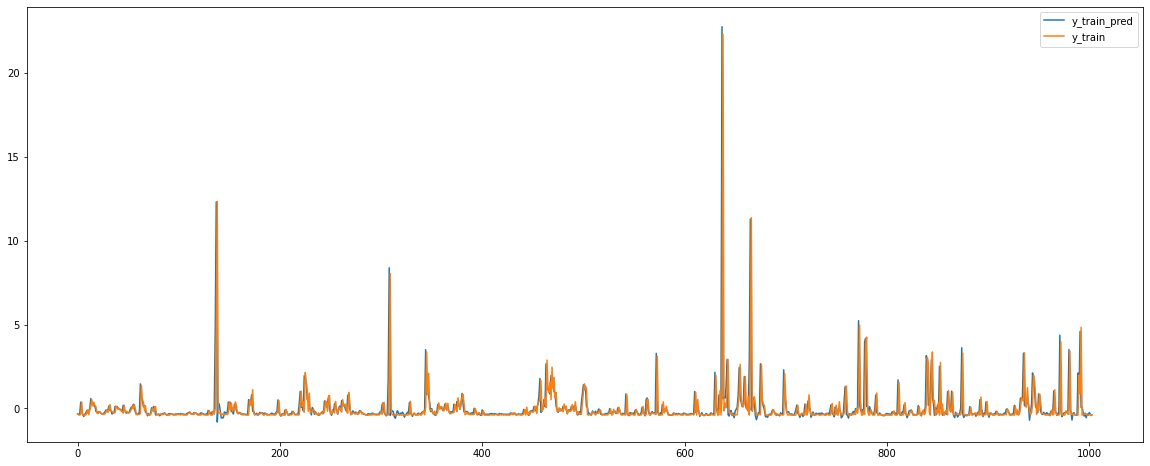

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y_train_predc2_cnn[1:])),y_train_predc2_cnn[1:],label ='y_train_pred' )
plt.plot(np.arange(len(y_train1.iloc[:,-1:])), y_train1.iloc[:,-1:], label ='y_train')
plt.legend(loc='upper right')

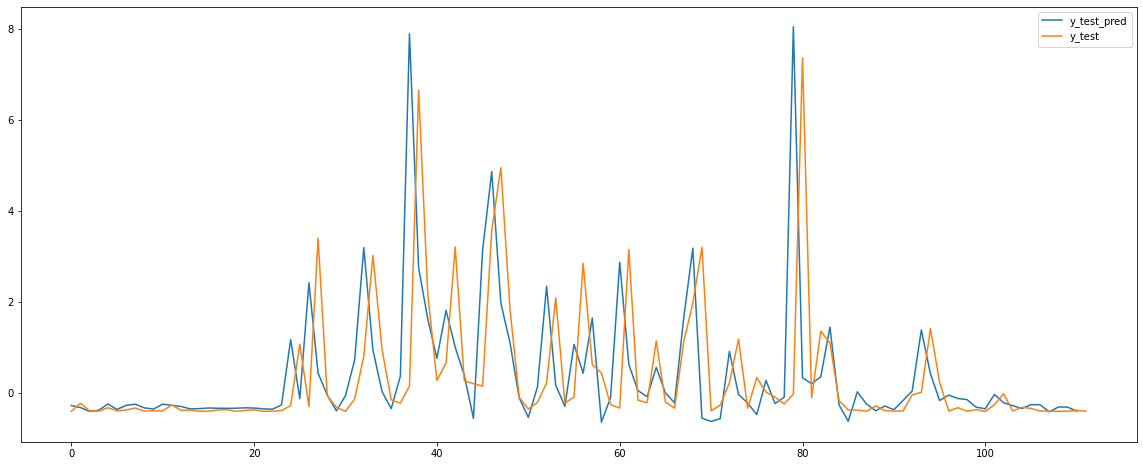

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y_test_predc2_cnn[1:])),y_test_predc2_cnn[1:],label ='y_test_pred' )
plt.plot(np.arange(len(y_test1.iloc[:,-1:])), y_test1.iloc[:,-1:], label ='y_test')
plt.legend(loc='best')

# Long-term forecast from long-term history

In [ ]:
n_points = len(df_new2)
train_points = int(9/10*n_points)
X_train2, X_test2 =df_new2.iloc[:train_points , [0 , 1 , 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]], df_new2.iloc[train_points :, [0 , 1 , 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]]
y_train2, y_test2 =df_new2.iloc[:train_points: , [19]],  df_new2.iloc[train_points: , [19]]
print("We have", len(X_train2), "training points and", X_test2.shape[0], "testing points")

We have 1004 training points and 112 testing points


In [ ]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
keras.backend.clear_session()

X_train2 = np.array(X_train2).reshape(X_train2.shape[0],X_train2.shape[1], 1)
X_test2 = np.array(X_test2).reshape(X_test2.shape[0],X_test2.shape[1], 1)
print(X_train2.shape)
print(X_test2.shape)

(1004, 20, 1)
(112, 20, 1)


In [ ]:
model3_cnn = Sequential()
model3_cnn.add(Conv1D(filters=15, kernel_size=3, activation='relu', input_shape=(X_train2.shape[1], 1)))
model3_cnn.add(MaxPooling1D(pool_size=3))
model3_cnn.add(Flatten())
model3_cnn.add(Dense(64, activation='relu'))
model3_cnn.add(Dense(1))
model3_cnn.compile(optimizer='adam', loss='mse')
model3_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 15)            60        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6, 15)             0         
_________________________________________________________________
flatten (Flatten)            (None, 90)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                5824      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 5,949
Trainable params: 5,949
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epoch = 100

model3_cnn.fit(X_train2, y_train2, epochs=nb_epoch)

Epoch 1/100
32/32 [==============================] - 0s 2ms/step - loss: 2.9209
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7304
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 0.4499
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.5479
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.8761
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.2330
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.1461
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.1909
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 0.1614
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0997
Epoch 11/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0794
Epoch 12/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0745
Epoch 13/100
32/32 [=================

In [ ]:
y_train_predc3_cnn = model3_cnn.predict(X_train2)
y_test_predc3_cnn = model3_cnn.predict(X_test2)

In [ ]:
mean_squared_error(y_train_predc3_cnn , y_train2.iloc[:,-1:])

0.030256913697791727

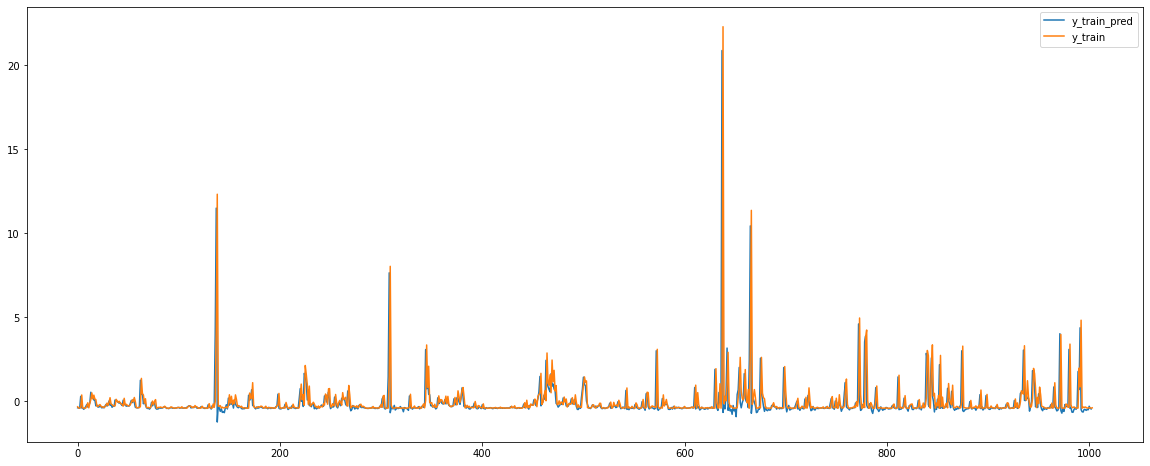

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y_train_predc3_cnn[1:])),y_train_predc3_cnn[1:],label ='y_train_pred' )
plt.plot(np.arange(len(y_train2.iloc[:,-1:])), y_train2.iloc[:,-1:], label ='y_train')
plt.legend(loc='upper right')

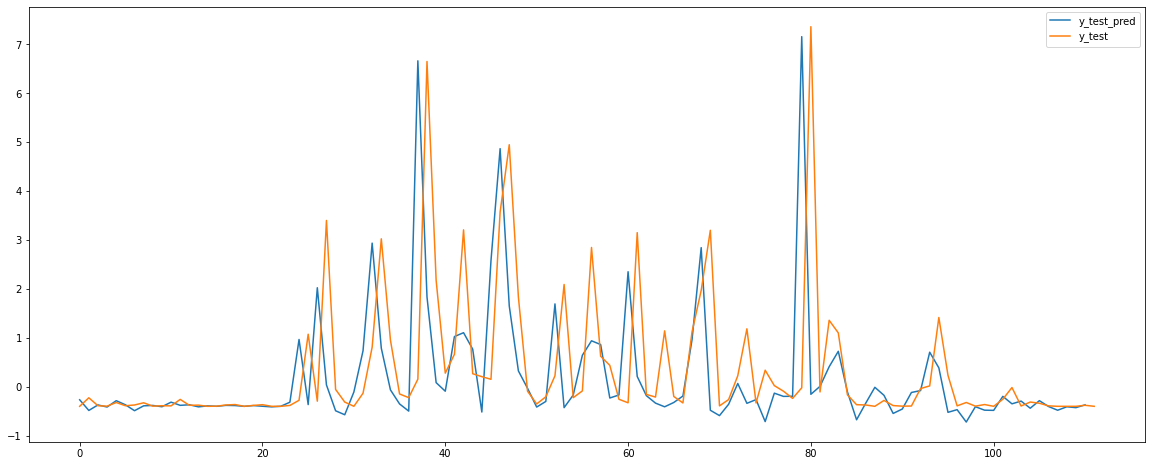

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y_test_predc3_cnn[1:])),y_test_predc3_cnn[1:],label ='y_test_pred' )
plt.plot(np.arange(len(y_test2.iloc[:,-1:])), y_test2.iloc[:,-1:], label ='y_test')
plt.legend(loc='best')